# Atari
ALE/Freeway-v5

## Import Libraries

In [1]:
#https://gymnasium.farama.org/environments/atari/
#pip install gymnasium[atari]
#pip install gymnasium[accept-rom-license]
#pip install moviepy
#https://www.youtube.com/watch?v=hCeJeq8U0lo&t=447s

import gymnasium as gym

#image preprocessing
from PIL import Image
from gymnasium.core import ObservationWrapper
from gymnasium.spaces.box import Box
import numpy as np
import matplotlib.pyplot as plt

#n-step experience replay
from collections import namedtuple, deque

#deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from gymnasium.wrappers import RecordVideo #enviornment monitoring
import random

from sklearn.model_selection import train_test_split #for splitting memory into training and testing
import pandas as pd

import shap
import math
import datetime

import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.multicomp as mc
from statsmodels.formula.api import ols

d:\Projects\repos\tu060\venv_research\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Deep Convelutional Q-Learning Agent

### Convelutional Neural Network

In [2]:
class CNN(nn.Module):
    def __init__(self, number_actions):
        super(CNN, self).__init__() # call nn module init
        #define what each layer in CNN is
        self.convolution1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)
        self.convolution2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.convolution3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2)

        #pass image through convolution layers and get neurons in a flatten layer to pass into a neural network
        self.fc1 = nn.Linear(in_features=self.count_neurons((1, 80, 80)), out_features=40) #1 is number of channels so black and white images, 80 80 is width and height
        self.fc2 = nn.Linear(in_features=40, out_features=number_actions)

    def count_neurons(self, image_dim):#image_dim for example 80px x 80px in size
        """Will give us the number of neurons after convolutions are applied"""
        #we need to first create a fake image (1 batch, 80px x 80px in size), * allows image_dim to be passed as a list
        fake_image = Variable(torch.rand(1, *image_dim))

        #pass image into first layer and max pool result then activate all neurons in max pool layer
        x = F.relu(F.max_pool2d(self.convolution1(fake_image), 3, 2)) #kernal size is 3, #stride is 2

        #pass image into second layer and max pool result then activate all neurons in max pool layer
        x = F.relu(F.max_pool2d(self.convolution2(x), 3, 2)) #kernal size is 3, #stride is 2

        #pass image into third layer and max pool result then activate all neurons in max pool layer
        x = F.relu(F.max_pool2d(self.convolution3(x), 3, 2)) #kernal size is 3, #stride is 2
        
        #now we get all pixels in third layer and flatten it. we get the data, view what's inside it then we get all the pixels and put it into 1 dimension
        return x.data.view(1, -1).size(1)
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.convolution1(x), 3, 2))
        x = F.relu(F.max_pool2d(self.convolution2(x), 3, 2))
        x = F.relu(F.max_pool2d(self.convolution3(x), 3, 2))
        #propagate data from convolutional layers to hidden layers by first flattening convolutional layers
        #flatten third layer by taking all pixels and all channels in third layer and arrange one after another
        x = x.view(x.size(0), -1) #RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x49 and 3136x40)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Softmax Policy

In [3]:
class SoftmaxPolicy(nn.Module):
    """data from the CNN is passed to softmax to play an action"""
    def __init__(self, T=100):
        super(SoftmaxPolicy, self).__init__()
        self.T = T

    def forward(self, outputs, number_actions=1):
        probs = F.softmax(outputs * self.T, dim=1)
        actions = probs.multinomial(num_samples=number_actions)
        return actions

### Agent (DCQ Learning System )

In [4]:
class DCQ():
    def __init__(self, CNN, SoftmaxPolicy):
        self.cnn = CNN
        self.softmax = SoftmaxPolicy

    def __call__(self, inputs):#comes from NStepProgress -> np.array([state])
        """similar to init function but it allows this AI class 
        instance to be treated like a function, not modifying the initial instance"""
        #receive images from the game by converting image into a numpy array then into a torch tensor, then put a torch tensor into a torch variable with a gradient
        input = Variable(torch.from_numpy(np.array(inputs, dtype = np.float32)))
        output = self.cnn(input)
        actions = self.softmax(output)
        return actions.data.numpy()

### Experience Replay

#### N-Step

In [5]:
class NStepProgress:
    """This class allows the AI to progress on several (n_step) steps"""
    def __init__(self, env, ai, n_step):
        self.ai = ai
        self.rewards = []
        self.env = env
        self.n_step = n_step
        self.step = namedtuple('Step', ['state', 'action', 'reward', 'done']) #Defining one Step
    def __iter__(self):
        observation, info = self.env.reset()
        history = deque()
        score = 0.0
        while True:
            #select an action
            action = self.ai(np.array([observation]))[0][0] #agent.update
            #get reward and next state
            observation, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated
            score += reward
            #add to stacked frame
            history.append(self.step(state=observation, action=action, reward=score, done=done))
            while len(history) > self.n_step + 1:
                history.popleft()
            if len(history) == self.n_step + 1:#create our stacked tuple when finished
                yield tuple(history)
            if done:
                if len(history) > self.n_step + 1:
                    history.popleft()
                while len(history) >= 1:
                    yield tuple(history)
                    history.popleft()
                self.rewards.append(score)
                score = 0.0
                observation, info  = self.env.reset()
                history.clear()
    
    def rewards_steps(self):
        rewards_steps = self.rewards
        self.rewards = []
        return rewards_steps

#### Replay Memory

In [6]:
class ReplayMemory:
    """This class is modified to do n-step learning"""
    def __init__(self, n_steps, capacity = 10000):
        self.capacity = capacity
        self.n_steps = n_steps
        self.n_steps_iter = iter(n_steps)
        self.buffer = deque()

    def sample_batch(self, batch_size): # creates an iterator that returns random batches
        ofs = 0 #we use an offset to keep track of starting index for each batch
        #we get samples from experience replay
        vals = list(self.buffer)
        #then randomly suffle them
        np.random.shuffle(vals)
        #now we check to see if we have enough samples in the buffer to make a batch if not we wait.
        while (ofs+1)*batch_size <= len(self.buffer):
            yield vals[ofs*batch_size:(ofs+1)*batch_size] #we slice from the offset position to the e.g 128 to 256
            ofs += 1

    def run_steps(self, samples):
        """Runs environment for 10 consecutive steps and"""
        while samples > 0:
            entry = next(self.n_steps_iter) # 10 consecutive steps of (state, action, reward, done)
            self.buffer.append(entry) # we put 200 for the current episode
            samples -= 1
        while len(self.buffer) > self.capacity: # we accumulate no more than the capacity (10000)
            self.buffer.popleft()

### N-Step Q-Learning
This is Eligibility Trace used in algorithms like SARSA, based on Asynchronous Methods for Deep Reinforcement Learning paper by Mnih et al 2016, except instead of using epsilon greedy policy we use softmax. Eligibility trace is a technique used to assign credit to past actions in a sequence of states and actions, and update the weights of a neural network model. It helps address the problem of delayed rewards and enable more effective learning in environments with long time delays between actions and their consequences. During the learning process, the eligibility trace is updated at each time step by decaying its value and adding the gradients of the weights with respect to the loss function. When an update is performed, the eligibility trace determines how much credit is assigned to each weight based on its previous contributions to the current outcome. By accumulating the eligibility traces over time, the algorithm can assign credit to actions that lead to future rewards, even if those rewards are delayed.

In [7]:
def eligibility_trace(batch, cnn, g=0.99):#batch is a sample of 128 10-steps where each step is ['state', 'action', 'reward', 'done'] so 1,280 transitions from memory
    """Asynchronous N-Step Q-Learning
    learns the cumulative rewards and cumulative targets
    on n-steps instead of one step like DQL"""
    gamma = g
    inputs = []
    targets = []
    for series in batch: #series of 10 transitions in our batch
        #get the first and last image as the input. Convert fron numpy to torch variable
        input = Variable(torch.from_numpy(np.array([series[0].state, series[-1].state], dtype=np.float32)))
        output = cnn(input) #this is the prediction from the ai

        #if the last transition of the series is not done we get the max q values
        cumulative_reward = 0.0 if series[-1].done else output[1].data.max()

        #start with the last step and go backwards to the first step
        for step in reversed(series[:-1]):#reversed goes backwards 
            state = series[0].state # first state we need. This is where we started
            target = output[0].data # this is the q value of the input state of the first step. This is what we thought we would get being in this state

            # what new reward did we actually get
            cumulative_reward = step.reward + gamma * cumulative_reward 
            target[series[0].action] = cumulative_reward # this is the q value we actually got

            inputs.append(state) # we append our first state
            targets.append(target) #we append the actual target q value for the first state

            #output the input and the target after being processed through eligibility_trace
            #we now have the first state and the target q values for the first state over 10 steps
            return torch.from_numpy(np.array(inputs, dtype=np.float32)), torch.stack(targets)#we stack targets together

### Image Preprocessing

In [8]:
class ImagePreprocessor(ObservationWrapper):
    """Custom Image Preprocessor similar to 
    Atari standard in gymnasium"""
    def __init__(self, env, height = 64, width = 64, grayscale = True, crop = lambda img: img):
        super(ImagePreprocessor, self).__init__(env)
        self.img_size = (height, width)
        self.grayscale = grayscale
        self.crop = crop
        n_colors = 1 if self.grayscale else 3
        self.observation_space = Box(0.0, 1.0, [n_colors, height, width])

    def observation(self, img):
        img = self.crop(img)
        img = Image.fromarray(img)
        img = img.resize(self.img_size)
        if self.grayscale:
            img = img.convert('L')  # Convert to grayscale
        else:
            img = img.convert('RGB')  # Convert to RGB if necessary

        #view preprocessed image
        #plt.imshow(img)
        #plt.show()

        img = np.array(img)
        #adds a new dimension to the array to represent the single color channel, resulting in the desired shape
        img = np.expand_dims(img, axis=2)
        
        #if img.ndim == 2:  # Add channel dimension if missing
        #    img = np.expand_dims(img, axis=2)
        img = np.transpose(img, (2, 0, 1))
        img = img.astype('float32') / 255

        #check dim of new image
        #print("image was preprocessed to: " + str("greyscale" if self.grayscale else "RGB") + " with shape " + str(img.shape))
        return img

### Moving Average Reward (for evaluation)

In [9]:
class MA:
    """creates the moving average reward on 
    100 steps to keep track of training performance"""
    def __init__(self, size):
        self.list_of_rewards = []
        self.average_rewards = []
        self.max_reward = 0
        self.cumulative_rewards = []
        self.size = size
    def add(self, rewards):
        if isinstance(rewards, list):
            self.list_of_rewards += rewards
        else:
            self.list_of_rewards.append(rewards)
        while len(self.list_of_rewards) > self.size:
            del self.list_of_rewards[0] # makes sure that we always have 100 elements of the latest rewards

        #get the latest high score if one exists
        if(len(self.list_of_rewards)>0):
            max_score = max(self.list_of_rewards)
            if max_score > self.max_reward:
                self.max_reward = max_score
            
        #collect score over time
        self.cumulative_rewards.append(sum(self.list_of_rewards))
    def average(self):
        if len(self.list_of_rewards) > 0:
            average_reward = np.mean(self.list_of_rewards)
            self.average_rewards.append(average_reward)
            return average_reward
        else:
            return 0.0  # or any other appropriate default value

In [10]:
#create table for evaluating capacity against reward
df_rewards = pd.DataFrame(columns=['capacity', 'episodes', 'reward'])

## Test Atari Environment Working

### Preview Atari Environment

In [11]:
env = gym.make('ALE/Freeway-v5')

In [12]:
a = env.action_space.n
print("Number of possible actions: ", a)

Number of possible actions:  3


In [13]:
env.unwrapped.get_action_meanings()

['NOOP', 'UP', 'DOWN']

In [14]:
observation, info = env.reset(seed=42)
observation, reward, terminated, truncated, info = env.step(env.action_space.sample())
print(observation.shape)
env.close()

(210, 160, 3)


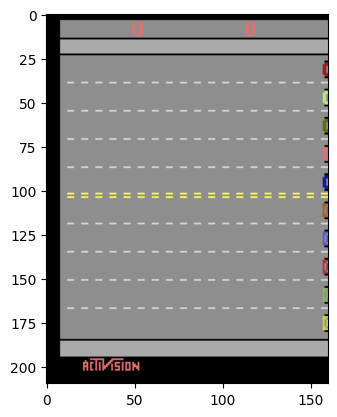

(210, 160, 3)


In [15]:
observation, info = env.reset(seed=42)
plt.imshow(observation)
plt.show()
print(observation.shape)

### Test Random Atari Player

```
env = gym.make('ALE/Freeway-v5', render_mode='human') # `human`, `rgb_array`.
observation, info = env.reset(seed=42)
```

```
episodes = 1
for episode in range(episodes):
    state = env.reset()
    done = False
    score = 0

    while not done:
        env.render()
        action = random.choice([0,1,2,3,4,5])
        observation, reward, terminated, truncated, info = env.step(action)
        score +=reward
        done = terminated or truncated
    print("episode: " + str(episode) + ", score: " + str(score))
    env.close()
```

## Atari Space Invaders Simulator Experiments

### 1,000,000 Capacity Size

#### Setup Preprocessed Environment

In [16]:
env = gym.make('ALE/Freeway-v5')

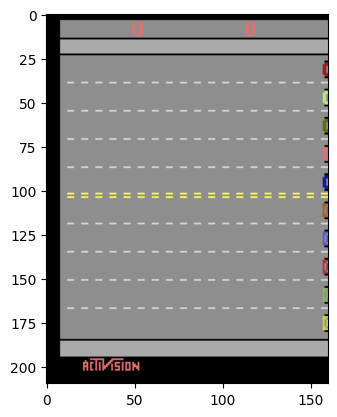

before image preprocessing: shape (210, 160, 3)


In [17]:
observation, info = env.reset(seed=42)
plt.imshow(observation)
plt.show()
print("before image preprocessing: shape " + str(observation.shape))

In [18]:
#We first preprocess the image by applying a greyscale and reducing the size to 80px. 
env = ImagePreprocessor(gym.make('ALE/Freeway-v5'), width=80, height=80, grayscale=True) #width=210, height=160 # , render_mode='human'

In [19]:
observation, info = env.reset(seed=42)

In [20]:
print(observation.shape) #we check that images are stacked

(1, 80, 80)


#### Create DCQL Agent

In [21]:
a = env.action_space.n # actions
g = 0.9 #gamma
c = 1000000 #10000 #memory capacity
m = 128 #memory sampling
l = 0.001 #learning rate
t = 1.0 #softmax policy temperature rate

#Build the agent
cnn = CNN(a)
softmax = SoftmaxPolicy(T=t) # T is temperature high means other actions are less explored
agent = DCQ(CNN=cnn, SoftmaxPolicy=softmax)

# Set up Experience Replay
n_steps = NStepProgress(env=env, ai=agent, n_step=10) #instead of learning every transition we learn every nth transition
memory = ReplayMemory(n_steps=n_steps, capacity=c) #last ten thousand steps

#set learning parameters
loss = nn.MSELoss()#calculate mean squared error loss
optimizer = optim.Adam(cnn.parameters(), lr=l) #use adams optimiser with a learning rate of 0.001

ma = MA(100)#get the average of the last 100 rewards

#### Simulate the environment

In [22]:
episodes = 200 #200

# Initialize an empty list to store the sampled inputs for SHAP Explainer
# set a sampling rate based on episodes as batches could be zero if not enough available at start

#define a random selection size such as 10%
random_select_size = math.ceil(episodes * 0.1) # 10%

# Create an array of random episode numbers
random_episodes = np.random.choice(range(episodes), size=random_select_size, replace=False)

# Initialize an empty list to store the sampled inputs for SHAP Explainer
sampling_episode = []
sampled_inputs = []
sampled_targets = []
episode_sampled = False  # Initialize the flag

for episode in range(episodes):
    #run the game for 200 runs of 10 steps and push sample transitions into memory
    memory.run_steps(samples=200)
    #sample 128 x10['state', 'action', 'reward', 'done'] or 1,280 transitions from memory if there is enough in memory to sample otherwise skip
    for batch in memory.sample_batch(m): #m=128
        #agent training
        #we get target discounted q values for the first state in the batch over 10 steps
        inputs, targets = eligibility_trace(batch, cnn, g)

        #We take some samples for shap.deepxplainer to create heatmap images or we use them for training. Not both!
        if episode in random_episodes and not episode_sampled:
            sampling_episode.append(episode) #record when sample was taken
            sampled_inputs.append(inputs)
            sampled_targets.append(targets)
            episode_sampled = True # Set the flag to True
        else:
            #we convert them to tensor variables
            inputs, targets = Variable(inputs), Variable(targets)

            #like during eligibility_trace we get predicted q values from the cnn model
            predictions = cnn(inputs)
            loss_error = loss(predictions, targets)
            optimizer.zero_grad()
            loss_error.backward()
            optimizer.step()
    
    episode_sampled = False # Reset the flag for the next iteration
            
    rewards_steps = n_steps.rewards_steps()
    ma.add(rewards_steps)
    avg_reward = ma.average()
    print("Epoch: %s, Average Reward: %s" % (str(episode), str(round(avg_reward,2))))
env.close()

Epoch: 0, Average Reward: 0.0
Epoch: 1, Average Reward: 0.0
Epoch: 2, Average Reward: 0.0
Epoch: 3, Average Reward: 0.0
Epoch: 4, Average Reward: 0.0
Epoch: 5, Average Reward: 0.0
Epoch: 6, Average Reward: 0.0
Epoch: 7, Average Reward: 0.0
Epoch: 8, Average Reward: 0.0
Epoch: 9, Average Reward: 0.0
Epoch: 10, Average Reward: 1.0
Epoch: 11, Average Reward: 1.0
Epoch: 12, Average Reward: 1.0
Epoch: 13, Average Reward: 1.0
Epoch: 14, Average Reward: 1.0
Epoch: 15, Average Reward: 1.0
Epoch: 16, Average Reward: 1.0
Epoch: 17, Average Reward: 1.0
Epoch: 18, Average Reward: 1.0
Epoch: 19, Average Reward: 1.0
Epoch: 20, Average Reward: 3.5
Epoch: 21, Average Reward: 3.5
Epoch: 22, Average Reward: 3.5
Epoch: 23, Average Reward: 3.5
Epoch: 24, Average Reward: 3.5
Epoch: 25, Average Reward: 3.5
Epoch: 26, Average Reward: 3.5
Epoch: 27, Average Reward: 3.5
Epoch: 28, Average Reward: 3.5
Epoch: 29, Average Reward: 3.5
Epoch: 30, Average Reward: 2.67
Epoch: 31, Average Reward: 2.67
Epoch: 32, Avera

#### HOW did the agent performed?

##### Agent's final score

In [23]:
#Current sum of all values in the reward window
print(ma.max_reward) #595.0

6.0


##### Rewards at given time/step

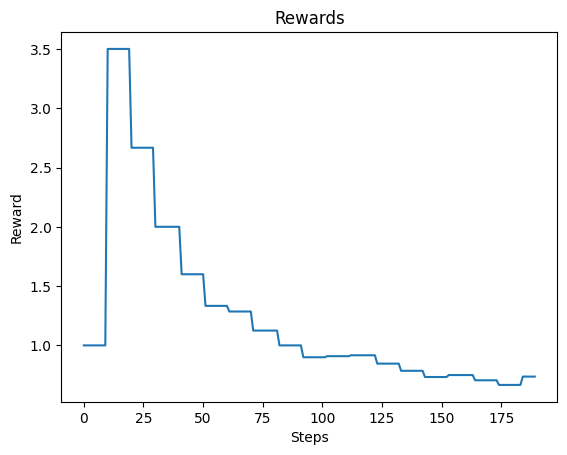

In [24]:
# Iterate over the rows of average_rewards and append them to df_rewards
for episode, reward in enumerate(ma.average_rewards):
    new_row = ["1M", episode, reward]
    df_rewards.loc[len(df_rewards)] = new_row
    
# Save and plot reward
plt.title("Rewards")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.plot(ma.average_rewards)
plt.show()

In [25]:
len(ma.average_rewards)#reward only counted if given.

190

##### Cumulative reward over time/step

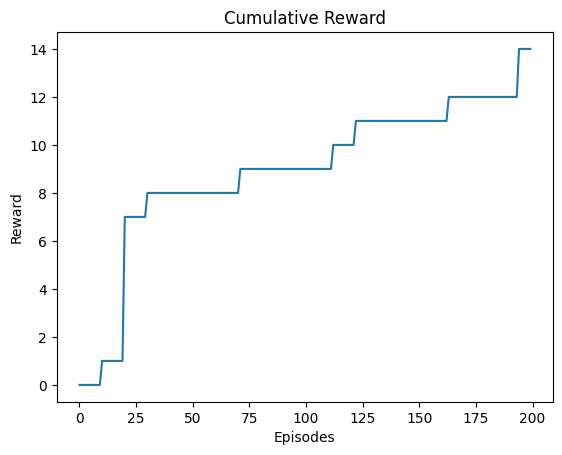

In [26]:
plt.title("Cumulative Reward")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(ma.cumulative_rewards)
plt.show()

#### WHY does the agent take an actions in the given state?

In [27]:
#we took 10% of experience replay samples as test data. The agent has not seen this yet
print(random_episodes)
len(sampled_inputs)

[ 96 168  45 160   0  51 159 134 186  94  87 132  91 158   3   2  97   7
  62  67]


20

In [28]:
x = sampling_episode
print(x)

[0, 2, 3, 7, 45, 51, 62, 67, 87, 91, 94, 96, 97, 132, 134, 158, 159, 160, 168, 186]


In [29]:
#After halfway through its training lets see why the agent took the actions it did
s = math.ceil(len(x)/2)
print(s)

10


In [30]:
# The first sample is a tensor of pixels indicating an image
sampled_inputs[s]

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.2627, 0.2627, 0.2627],
          [0.0000, 0.0000, 0.0000,  ..., 0.5804, 0.5804, 0.5804],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]])

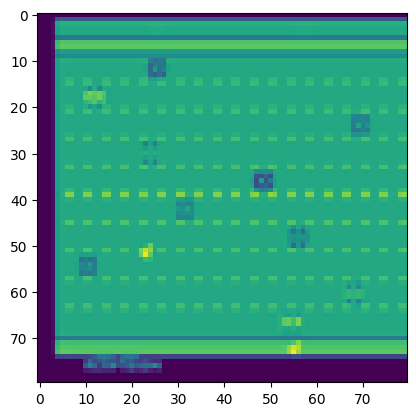

In [45]:
# we can see what that image is
plt.imshow(sampled_inputs[s].view(80, 80, 1))
plt.show()

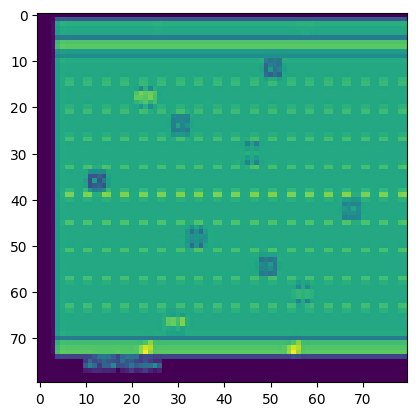

In [46]:
# we then see what the next image is
plt.imshow(sampled_inputs[s+1].view(80, 80, 1))
plt.show()

In [47]:
# we see what Q values were calculated for each action for first image
sampled_targets[s]
#['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

tensor([[6.8491, 6.8666, 6.1743]])

In [48]:
# we see what Q values were calculated for each action for second image
sampled_targets[s+1]
#['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

tensor([[6.4651, 5.8163, 6.0841]])

In [49]:
background = sampled_inputs[s] #we use the first image for shap explainer
test_image = sampled_inputs[s+1] #we use the second image for testing shap explainer

In [50]:
e = shap.DeepExplainer(cnn, background) # train shap explainer

In [51]:
shap_values = e.shap_values(test_image) #get shap values for second image

In [52]:
shap_values

[array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]]]),
 array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]]]),
 array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]]])]

In [53]:
shap_values = torch.from_numpy(np.array(shap_values, dtype=np.float32)) #convert shap values into a tensor

In [54]:
shap_values.shape #this tensor has 6 samples, each having 1 channel, a height of 1, a width of 80, and a depth of 80.

torch.Size([3, 1, 1, 80, 80])

In [55]:
shap_values[0].shape # shap_value sample is an image

torch.Size([1, 1, 80, 80])

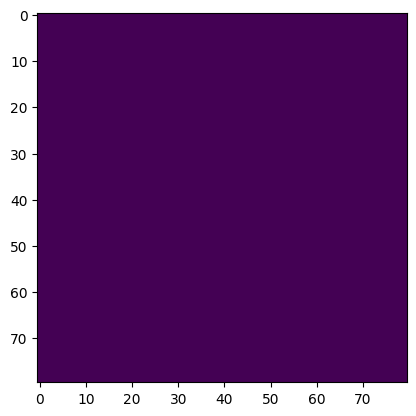

In [56]:
plt.imshow(shap_values[0].view(80, 80, 1))
plt.show() # image shows the importance of each action


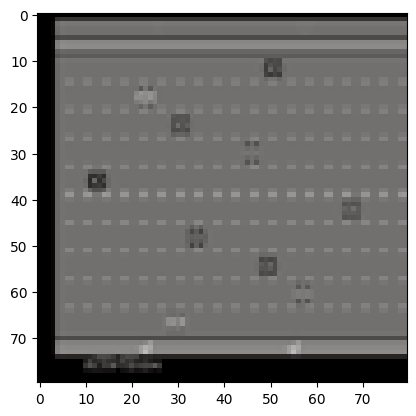

In [57]:
plt.imshow(sampled_inputs[s+1].view(80, 80, 1), cmap='gray') #['NOOP', 'FIRE', 'RIGHT', 'LEFT']
plt.imshow(shap_values[0].view(80, 80, 1), cmap='hot', alpha=0.1) #0=NOOP
plt.imshow(shap_values[1].view(80, 80, 1), cmap='hot', alpha=0.1) #1=UP
plt.imshow(shap_values[2].view(80, 80, 1), cmap='hot', alpha=0.1) #2=DOWN

### 500,000 Capacity Size

#### Setup Preprocessed Environment

In [58]:
env = gym.make('ALE/Freeway-v5')

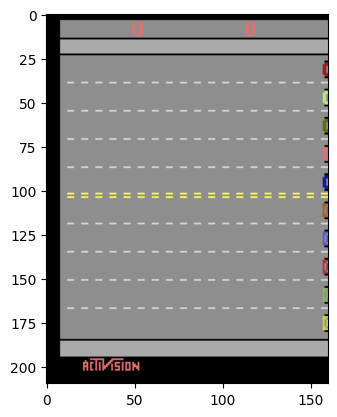

before image preprocessing: shape (210, 160, 3)


In [59]:
observation, info = env.reset(seed=42)
plt.imshow(observation)
plt.show()
print("before image preprocessing: shape " + str(observation.shape))

In [60]:
#We first preprocess the image by applying a greyscale and reducing the size to 80px. 
env = ImagePreprocessor(gym.make('ALE/Freeway-v5'), width=80, height=80, grayscale=True) #width=210, height=160 # , render_mode='human'

In [61]:
observation, info = env.reset(seed=42)

In [62]:
print(observation.shape) #we check that images are stacked

(1, 80, 80)


#### Create DCQL Agent

In [63]:
a = env.action_space.n # actions
g = 0.9 #gamma
c = 500000 #10000 #memory capacity
m = 128 #memory sampling
l = 0.001 #learning rate
t = 1.0 #softmax policy temperature rate

#Build the agent
cnn = CNN(a)
softmax = SoftmaxPolicy(T=t) # T is temperature high means other actions are less explored
agent = DCQ(CNN=cnn, SoftmaxPolicy=softmax)

# Set up Experience Replay
n_steps = NStepProgress(env=env, ai=agent, n_step=10) #instead of learning every transition we learn every nth transition
memory = ReplayMemory(n_steps=n_steps, capacity=c) #last ten thousand steps

#set learning parameters
loss = nn.MSELoss()#calculate mean squared error loss
optimizer = optim.Adam(cnn.parameters(), lr=l) #use adams optimiser with a learning rate of 0.001

ma = MA(100)#get the average of the last 100 rewards

#### Simulate the environment

In [64]:
episodes = 200 #200

# Initialize an empty list to store the sampled inputs for SHAP Explainer
# set a sampling rate based on episodes as batches could be zero if not enough available at start

#define a random selection size such as 10%
random_select_size = math.ceil(episodes * 0.1) # 10%

# Create an array of random episode numbers
random_episodes = np.random.choice(range(episodes), size=random_select_size, replace=False)

# Initialize an empty list to store the sampled inputs for SHAP Explainer
sampling_episode = []
sampled_inputs = []
sampled_targets = []
episode_sampled = False  # Initialize the flag

for episode in range(episodes):
    #run the game for 200 runs of 10 steps and push sample transitions into memory
    memory.run_steps(samples=200)
    #sample 128 x10['state', 'action', 'reward', 'done'] or 1,280 transitions from memory if there is enough in memory to sample otherwise skip
    for batch in memory.sample_batch(m): #m=128
        #agent training
        #we get target discounted q values for the first state in the batch over 10 steps
        inputs, targets = eligibility_trace(batch, cnn, g)

        #We take some samples for shap.deepxplainer to create heatmap images or we use them for training. Not both!
        if episode in random_episodes and not episode_sampled:
            sampling_episode.append(episode) #record when sample was taken
            sampled_inputs.append(inputs)
            sampled_targets.append(targets)
            episode_sampled = True # Set the flag to True
        else:
            #we convert them to tensor variables
            inputs, targets = Variable(inputs), Variable(targets)

            #like during eligibility_trace we get predicted q values from the cnn model
            predictions = cnn(inputs)
            loss_error = loss(predictions, targets)
            optimizer.zero_grad()
            loss_error.backward()
            optimizer.step()
    
    episode_sampled = False # Reset the flag for the next iteration
            
    rewards_steps = n_steps.rewards_steps()
    ma.add(rewards_steps)
    avg_reward = ma.average()
    print("Epoch: %s, Average Reward: %s" % (str(episode), str(round(avg_reward,2))))
env.close()

Epoch: 0, Average Reward: 0.0
Epoch: 1, Average Reward: 0.0
Epoch: 2, Average Reward: 0.0
Epoch: 3, Average Reward: 0.0
Epoch: 4, Average Reward: 0.0


Epoch: 5, Average Reward: 0.0
Epoch: 6, Average Reward: 0.0
Epoch: 7, Average Reward: 0.0
Epoch: 8, Average Reward: 0.0
Epoch: 9, Average Reward: 0.0
Epoch: 10, Average Reward: 0.0
Epoch: 11, Average Reward: 0.0
Epoch: 12, Average Reward: 0.0
Epoch: 13, Average Reward: 0.0
Epoch: 14, Average Reward: 0.0
Epoch: 15, Average Reward: 0.0
Epoch: 16, Average Reward: 0.0
Epoch: 17, Average Reward: 0.0
Epoch: 18, Average Reward: 0.0
Epoch: 19, Average Reward: 0.0
Epoch: 20, Average Reward: 0.0
Epoch: 21, Average Reward: 0.0
Epoch: 22, Average Reward: 0.0
Epoch: 23, Average Reward: 0.0
Epoch: 24, Average Reward: 0.0
Epoch: 25, Average Reward: 0.0
Epoch: 26, Average Reward: 0.0
Epoch: 27, Average Reward: 0.0
Epoch: 28, Average Reward: 0.0
Epoch: 29, Average Reward: 0.0
Epoch: 30, Average Reward: 0.0
Epoch: 31, Average Reward: 0.0
Epoch: 32, Average Reward: 0.0
Epoch: 33, Average Reward: 0.0
Epoch: 34, Average Reward: 0.0
Epoch: 35, Average Reward: 0.0
Epoch: 36, Average Reward: 0.0
Epoch: 37, Av

#### HOW did the agent performed?

##### Agent's final score

In [65]:
#Current sum of all values in the reward window
print(ma.max_reward) #595.0

0


##### Rewards at given time/step

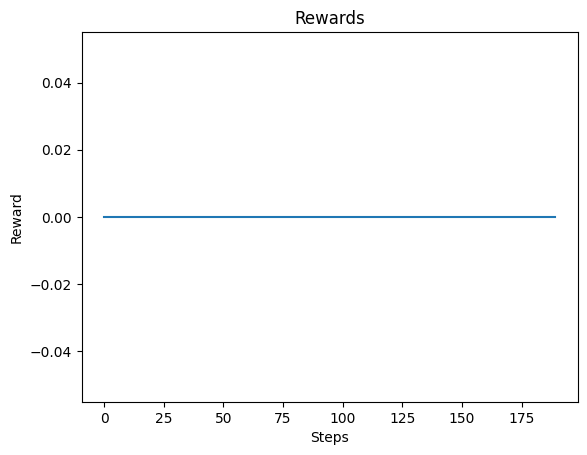

In [66]:
# Iterate over the rows of average_rewards and append them to df_rewards
for episode, reward in enumerate(ma.average_rewards):
    new_row = ["500k", episode, reward]
    df_rewards.loc[len(df_rewards)] = new_row
    
# Save and plot reward
plt.title("Rewards")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.plot(ma.average_rewards)
plt.show()

In [67]:
len(ma.average_rewards)#reward only counted if given.

190

##### Cumulative reward over time/step

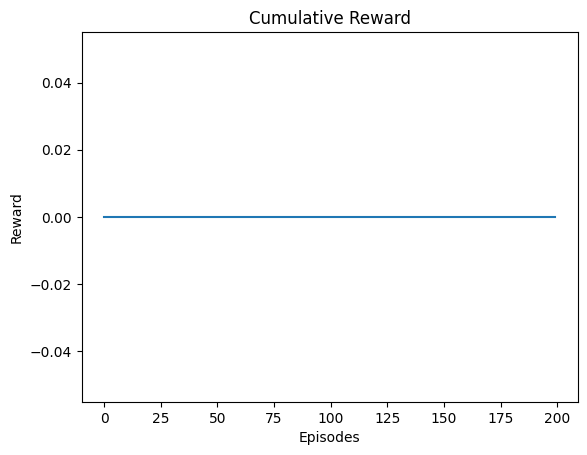

In [68]:
plt.title("Cumulative Reward")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(ma.cumulative_rewards)
plt.show()

#### WHY does the agent take an actions in the given state?

In [69]:
#we took 10% of experience replay samples as test data. The agent has not seen this yet
print(random_episodes)
len(sampled_inputs)

[ 45  76  29  55  75 158  74  44  13 188 172 136 123   7  31 184  11 196
  49  52]


20

In [70]:
x = sampling_episode
print(x)

[7, 11, 13, 29, 31, 44, 45, 49, 52, 55, 74, 75, 76, 123, 136, 158, 172, 184, 188, 196]


In [71]:
#After halfway through its training lets see why the agent took the actions it did
s = math.ceil(len(x)/2)
print(s)

10


In [72]:
# The first sample is a tensor of pixels indicating an image
sampled_inputs[s]

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.2627, 0.2627, 0.2627],
          [0.0000, 0.0000, 0.0000,  ..., 0.5804, 0.5804, 0.5804],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]])

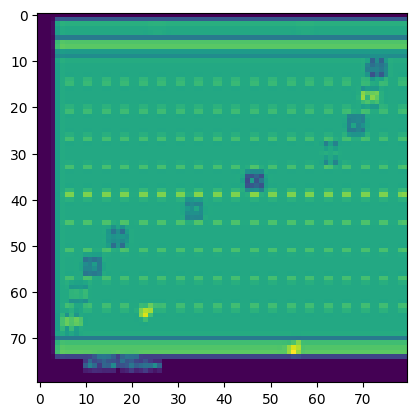

In [73]:
# we can see what that image is
plt.imshow(sampled_inputs[s].view(80, 80, 1))
plt.show()

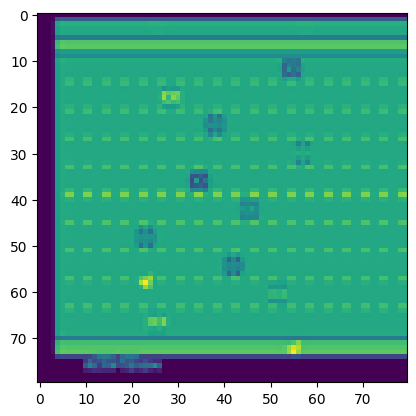

In [74]:
# we then see what the next image is
plt.imshow(sampled_inputs[s+1].view(80, 80, 1))
plt.show()

In [75]:
# we see what Q values were calculated for each action for first image
sampled_targets[s]
#['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

tensor([[1.3769e-04, 9.6366e-05, 1.5299e-04]])

In [76]:
# we see what Q values were calculated for each action for second image
sampled_targets[s+1]
#['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

tensor([[0.0010, 0.0011, 0.0011]])

In [77]:
background = sampled_inputs[s] #we use the first image for shap explainer
test_image = sampled_inputs[s+1] #we use the second image for testing shap explainer

In [78]:
e = shap.DeepExplainer(cnn, background) # train shap explainer

In [79]:
shap_values = e.shap_values(test_image) #get shap values for second image

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [80]:
shap_values

[array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]]]),
 array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]]]),
 array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]]])]

In [81]:
shap_values = torch.from_numpy(np.array(shap_values, dtype=np.float32)) #convert shap values into a tensor

In [82]:
shap_values.shape #this tensor has 6 samples, each having 1 channel, a height of 1, a width of 80, and a depth of 80.

torch.Size([3, 1, 1, 80, 80])

In [83]:
shap_values[0].shape # shap_value sample is an image

torch.Size([1, 1, 80, 80])

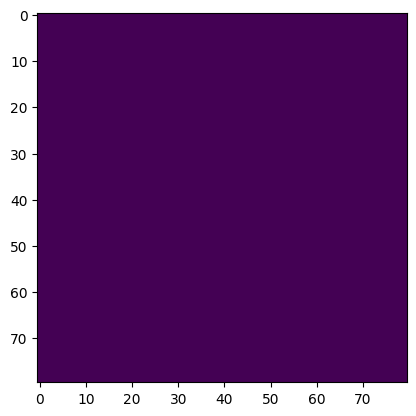

In [84]:
plt.imshow(shap_values[0].view(80, 80, 1))
plt.show() # image shows the importance of each action


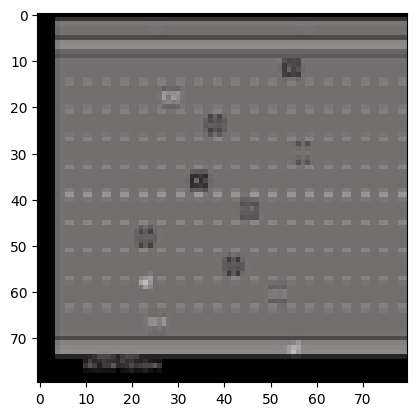

In [85]:
plt.imshow(sampled_inputs[s+1].view(80, 80, 1), cmap='gray') #['NOOP', 'FIRE', 'RIGHT', 'LEFT']
plt.imshow(shap_values[0].view(80, 80, 1), cmap='hot', alpha=0.1) #0=NOOP
plt.imshow(shap_values[1].view(80, 80, 1), cmap='hot', alpha=0.1) #1=UP
plt.imshow(shap_values[2].view(80, 80, 1), cmap='hot', alpha=0.1) #2=DOWN

### 100,000 Capacity Size

#### Setup Preprocessed Environment

In [86]:
env = gym.make('ALE/Freeway-v5')

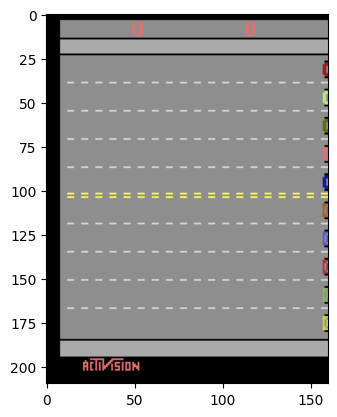

before image preprocessing: shape (210, 160, 3)


In [87]:
observation, info = env.reset(seed=42)
plt.imshow(observation)
plt.show()
print("before image preprocessing: shape " + str(observation.shape))

In [88]:
#We first preprocess the image by applying a greyscale and reducing the size to 80px. 
env = ImagePreprocessor(gym.make('ALE/Freeway-v5'), width=80, height=80, grayscale=True) #width=210, height=160 # , render_mode='human'

In [89]:
observation, info = env.reset(seed=42)

In [90]:
print(observation.shape) #we check that images are stacked

(1, 80, 80)


#### Create DCQL Agent

In [91]:
a = env.action_space.n # actions
g = 0.9 #gamma
c = 100000 #10000 #memory capacity
m = 128 #memory sampling
l = 0.001 #learning rate
t = 1.0 #softmax policy temperature rate

#Build the agent
cnn = CNN(a)
softmax = SoftmaxPolicy(T=t) # T is temperature high means other actions are less explored
agent = DCQ(CNN=cnn, SoftmaxPolicy=softmax)

# Set up Experience Replay
n_steps = NStepProgress(env=env, ai=agent, n_step=10) #instead of learning every transition we learn every nth transition
memory = ReplayMemory(n_steps=n_steps, capacity=c) #last ten thousand steps

#set learning parameters
loss = nn.MSELoss()#calculate mean squared error loss
optimizer = optim.Adam(cnn.parameters(), lr=l) #use adams optimiser with a learning rate of 0.001

ma = MA(100)#get the average of the last 100 rewards

#### Simulate the environment

In [92]:
episodes = 200 #200

# Initialize an empty list to store the sampled inputs for SHAP Explainer
# set a sampling rate based on episodes as batches could be zero if not enough available at start

#define a random selection size such as 10%
random_select_size = math.ceil(episodes * 0.1) # 10%

# Create an array of random episode numbers
random_episodes = np.random.choice(range(episodes), size=random_select_size, replace=False)

# Initialize an empty list to store the sampled inputs for SHAP Explainer
sampling_episode = []
sampled_inputs = []
sampled_targets = []
episode_sampled = False  # Initialize the flag

for episode in range(episodes):
    #run the game for 200 runs of 10 steps and push sample transitions into memory
    memory.run_steps(samples=200)
    #sample 128 x10['state', 'action', 'reward', 'done'] or 1,280 transitions from memory if there is enough in memory to sample otherwise skip
    for batch in memory.sample_batch(m): #m=128
        #agent training
        #we get target discounted q values for the first state in the batch over 10 steps
        inputs, targets = eligibility_trace(batch, cnn, g)

        #We take some samples for shap.deepxplainer to create heatmap images or we use them for training. Not both!
        if episode in random_episodes and not episode_sampled:
            sampling_episode.append(episode) #record when sample was taken
            sampled_inputs.append(inputs)
            sampled_targets.append(targets)
            episode_sampled = True # Set the flag to True
        else:
            #we convert them to tensor variables
            inputs, targets = Variable(inputs), Variable(targets)

            #like during eligibility_trace we get predicted q values from the cnn model
            predictions = cnn(inputs)
            loss_error = loss(predictions, targets)
            optimizer.zero_grad()
            loss_error.backward()
            optimizer.step()
    
    episode_sampled = False # Reset the flag for the next iteration
            
    rewards_steps = n_steps.rewards_steps()
    ma.add(rewards_steps)
    avg_reward = ma.average()
    print("Epoch: %s, Average Reward: %s" % (str(episode), str(round(avg_reward,2))))
env.close()

Epoch: 0, Average Reward: 0.0
Epoch: 1, Average Reward: 0.0
Epoch: 2, Average Reward: 0.0
Epoch: 3, Average Reward: 0.0
Epoch: 4, Average Reward: 0.0
Epoch: 5, Average Reward: 0.0
Epoch: 6, Average Reward: 0.0
Epoch: 7, Average Reward: 0.0
Epoch: 8, Average Reward: 0.0
Epoch: 9, Average Reward: 0.0
Epoch: 10, Average Reward: 0.0
Epoch: 11, Average Reward: 0.0
Epoch: 12, Average Reward: 0.0
Epoch: 13, Average Reward: 0.0
Epoch: 14, Average Reward: 0.0
Epoch: 15, Average Reward: 0.0
Epoch: 16, Average Reward: 0.0
Epoch: 17, Average Reward: 0.0
Epoch: 18, Average Reward: 0.0
Epoch: 19, Average Reward: 0.0
Epoch: 20, Average Reward: 0.0
Epoch: 21, Average Reward: 0.0
Epoch: 22, Average Reward: 0.0
Epoch: 23, Average Reward: 0.0
Epoch: 24, Average Reward: 0.0
Epoch: 25, Average Reward: 0.0
Epoch: 26, Average Reward: 0.0
Epoch: 27, Average Reward: 0.0
Epoch: 28, Average Reward: 0.0
Epoch: 29, Average Reward: 0.0
Epoch: 30, Average Reward: 0.0
Epoch: 31, Average Reward: 0.0
Epoch: 32, Average

#### HOW did the agent performed?

##### Agent's final score

In [93]:
#Current sum of all values in the reward window
print(ma.max_reward) #595.0

0


##### Rewards at given time/step

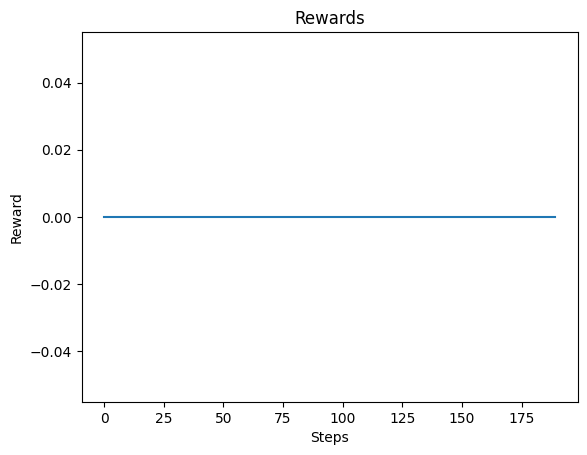

In [94]:
# Iterate over the rows of average_rewards and append them to df_rewards
for episode, reward in enumerate(ma.average_rewards):
    new_row = ["100k", episode, reward]
    df_rewards.loc[len(df_rewards)] = new_row
    
# Save and plot reward
plt.title("Rewards")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.plot(ma.average_rewards)
plt.show()

In [95]:
len(ma.average_rewards)#reward only counted if given.

190

##### Cumulative reward over time/step

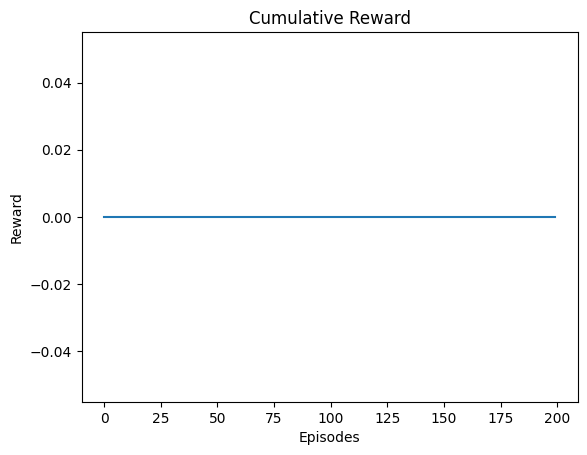

In [96]:
plt.title("Cumulative Reward")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(ma.cumulative_rewards)
plt.show()

#### WHY does the agent take an actions in the given state?

In [97]:
#we took 10% of experience replay samples as test data. The agent has not seen this yet
print(random_episodes)
len(sampled_inputs)

[152  84 166  25   0  93 104  30  91 193 136 144  98 159 117 119  89  78
 178  12]


20

In [98]:
x = sampling_episode
print(x)

[0, 12, 25, 30, 78, 84, 89, 91, 93, 98, 104, 117, 119, 136, 144, 152, 159, 166, 178, 193]


In [99]:
#After halfway through its training lets see why the agent took the actions it did
s = math.ceil(len(x)/2)
print(s)

10


In [100]:
# The first sample is a tensor of pixels indicating an image
sampled_inputs[s]

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.2627, 0.2627, 0.2627],
          [0.0000, 0.0000, 0.0000,  ..., 0.5804, 0.5804, 0.5804],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]])

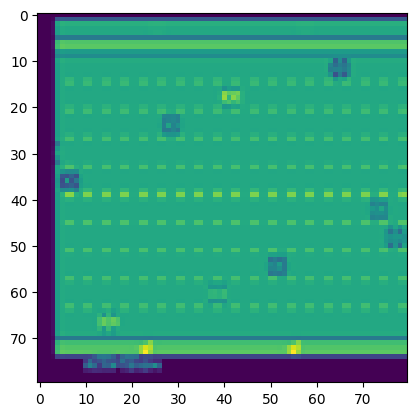

In [101]:
# we can see what that image is
plt.imshow(sampled_inputs[s].view(80, 80, 1))
plt.show()

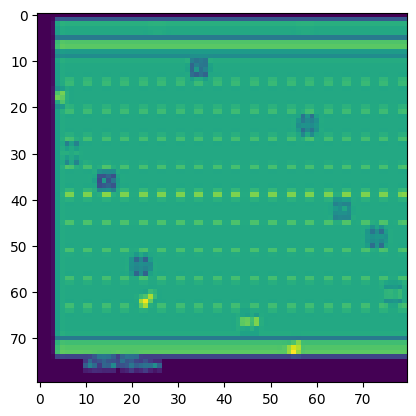

In [102]:
# we then see what the next image is
plt.imshow(sampled_inputs[s+1].view(80, 80, 1))
plt.show()

In [103]:
# we see what Q values were calculated for each action for first image
sampled_targets[s]
#['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

tensor([[0.0017, 0.0020, 0.0019]])

In [104]:
# we see what Q values were calculated for each action for second image
sampled_targets[s+1]
#['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

tensor([[1.5087e-08, 1.6764e-08, 1.6065e-08]])

In [105]:
background = sampled_inputs[s] #we use the first image for shap explainer
test_image = sampled_inputs[s+1] #we use the second image for testing shap explainer

In [106]:
e = shap.DeepExplainer(cnn, background) # train shap explainer

In [107]:
shap_values = e.shap_values(test_image) #get shap values for second image

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [108]:
shap_values

[array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]]]),
 array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]]]),
 array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]]])]

In [109]:
shap_values = torch.from_numpy(np.array(shap_values, dtype=np.float32)) #convert shap values into a tensor

In [110]:
shap_values.shape #this tensor has 6 samples, each having 1 channel, a height of 1, a width of 80, and a depth of 80.

torch.Size([3, 1, 1, 80, 80])

In [111]:
shap_values[0].shape # shap_value sample is an image

torch.Size([1, 1, 80, 80])

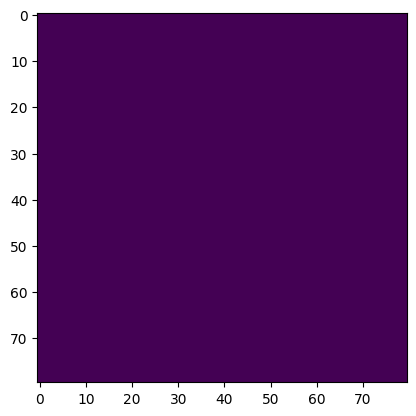

In [112]:
plt.imshow(shap_values[0].view(80, 80, 1))
plt.show() # image shows the importance of each action


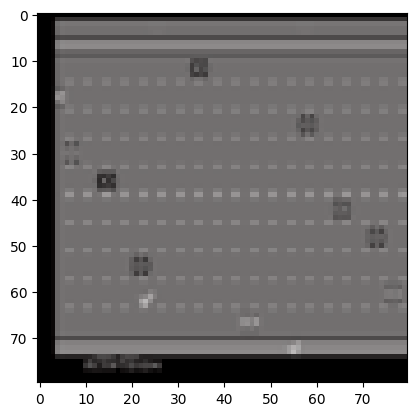

In [113]:
plt.imshow(sampled_inputs[s+1].view(80, 80, 1), cmap='gray') #['NOOP', 'FIRE', 'RIGHT', 'LEFT']
plt.imshow(shap_values[0].view(80, 80, 1), cmap='hot', alpha=0.1) #0=NOOP
plt.imshow(shap_values[1].view(80, 80, 1), cmap='hot', alpha=0.1) #1=UP
plt.imshow(shap_values[2].view(80, 80, 1), cmap='hot', alpha=0.1) #2=DOWN

### 50,000 Capacity Size

#### Setup Preprocessed Environment

In [114]:
env = gym.make('ALE/Freeway-v5')

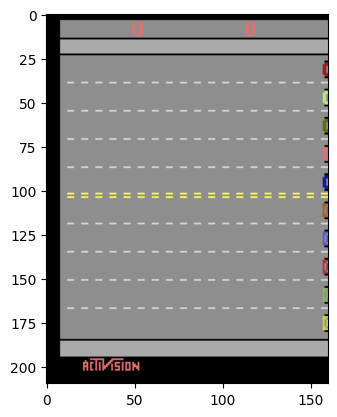

before image preprocessing: shape (210, 160, 3)


In [115]:
observation, info = env.reset(seed=42)
plt.imshow(observation)
plt.show()
print("before image preprocessing: shape " + str(observation.shape))

In [116]:
#We first preprocess the image by applying a greyscale and reducing the size to 80px. 
env = ImagePreprocessor(gym.make('ALE/Freeway-v5'), width=80, height=80, grayscale=True) #width=210, height=160 # , render_mode='human'

In [117]:
observation, info = env.reset(seed=42)

In [118]:
print(observation.shape) #we check that images are stacked

(1, 80, 80)


#### Create DCQL Agent

In [119]:
a = env.action_space.n # actions
g = 0.9 #gamma
c = 50000 #10000 #memory capacity
m = 128 #memory sampling
l = 0.001 #learning rate
t = 1.0 #softmax policy temperature rate

#Build the agent
cnn = CNN(a)
softmax = SoftmaxPolicy(T=t) # T is temperature high means other actions are less explored
agent = DCQ(CNN=cnn, SoftmaxPolicy=softmax)

# Set up Experience Replay
n_steps = NStepProgress(env=env, ai=agent, n_step=10) #instead of learning every transition we learn every nth transition
memory = ReplayMemory(n_steps=n_steps, capacity=c) #last ten thousand steps

#set learning parameters
loss = nn.MSELoss()#calculate mean squared error loss
optimizer = optim.Adam(cnn.parameters(), lr=l) #use adams optimiser with a learning rate of 0.001

ma = MA(100)#get the average of the last 100 rewards

#### Simulate the environment

In [120]:
episodes = 200 #200

# Initialize an empty list to store the sampled inputs for SHAP Explainer
# set a sampling rate based on episodes as batches could be zero if not enough available at start

#define a random selection size such as 10%
random_select_size = math.ceil(episodes * 0.1) # 10%

# Create an array of random episode numbers
random_episodes = np.random.choice(range(episodes), size=random_select_size, replace=False)

# Initialize an empty list to store the sampled inputs for SHAP Explainer
sampling_episode = []
sampled_inputs = []
sampled_targets = []
episode_sampled = False  # Initialize the flag

for episode in range(episodes):
    #run the game for 200 runs of 10 steps and push sample transitions into memory
    memory.run_steps(samples=200)
    #sample 128 x10['state', 'action', 'reward', 'done'] or 1,280 transitions from memory if there is enough in memory to sample otherwise skip
    for batch in memory.sample_batch(m): #m=128
        #agent training
        #we get target discounted q values for the first state in the batch over 10 steps
        inputs, targets = eligibility_trace(batch, cnn, g)

        #We take some samples for shap.deepxplainer to create heatmap images or we use them for training. Not both!
        if episode in random_episodes and not episode_sampled:
            sampling_episode.append(episode) #record when sample was taken
            sampled_inputs.append(inputs)
            sampled_targets.append(targets)
            episode_sampled = True # Set the flag to True
        else:
            #we convert them to tensor variables
            inputs, targets = Variable(inputs), Variable(targets)

            #like during eligibility_trace we get predicted q values from the cnn model
            predictions = cnn(inputs)
            loss_error = loss(predictions, targets)
            optimizer.zero_grad()
            loss_error.backward()
            optimizer.step()
    
    episode_sampled = False # Reset the flag for the next iteration
            
    rewards_steps = n_steps.rewards_steps()
    ma.add(rewards_steps)
    avg_reward = ma.average()
    print("Epoch: %s, Average Reward: %s" % (str(episode), str(round(avg_reward,2))))
env.close()

Epoch: 0, Average Reward: 0.0
Epoch: 1, Average Reward: 0.0
Epoch: 2, Average Reward: 0.0
Epoch: 3, Average Reward: 0.0
Epoch: 4, Average Reward: 0.0
Epoch: 5, Average Reward: 0.0
Epoch: 6, Average Reward: 0.0
Epoch: 7, Average Reward: 0.0
Epoch: 8, Average Reward: 0.0
Epoch: 9, Average Reward: 0.0
Epoch: 10, Average Reward: 0.0
Epoch: 11, Average Reward: 0.0
Epoch: 12, Average Reward: 0.0
Epoch: 13, Average Reward: 0.0
Epoch: 14, Average Reward: 0.0
Epoch: 15, Average Reward: 0.0
Epoch: 16, Average Reward: 0.0
Epoch: 17, Average Reward: 0.0
Epoch: 18, Average Reward: 0.0
Epoch: 19, Average Reward: 0.0
Epoch: 20, Average Reward: 0.0
Epoch: 21, Average Reward: 0.0
Epoch: 22, Average Reward: 0.0
Epoch: 23, Average Reward: 0.0
Epoch: 24, Average Reward: 0.0
Epoch: 25, Average Reward: 0.0
Epoch: 26, Average Reward: 0.0
Epoch: 27, Average Reward: 0.0
Epoch: 28, Average Reward: 0.0
Epoch: 29, Average Reward: 0.0
Epoch: 30, Average Reward: 0.0
Epoch: 31, Average Reward: 0.0
Epoch: 32, Average

#### HOW did the agent performed?

##### Agent's final score

In [121]:
#Current sum of all values in the reward window
print(ma.max_reward) #595.0

0


##### Rewards at given time/step

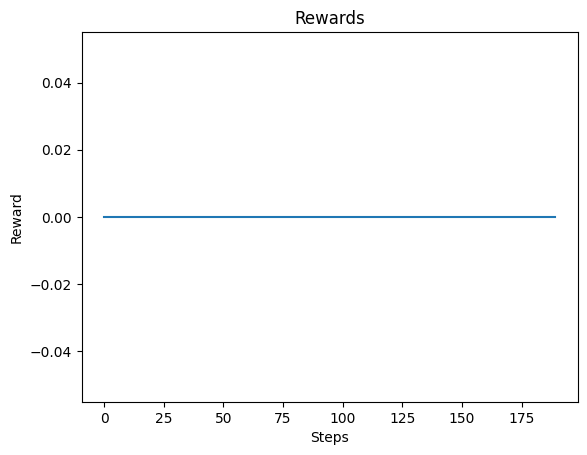

In [122]:
# Iterate over the rows of average_rewards and append them to df_rewards
for episode, reward in enumerate(ma.average_rewards):
    new_row = ["50k", episode, reward]
    df_rewards.loc[len(df_rewards)] = new_row
    
# Save and plot reward
plt.title("Rewards")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.plot(ma.average_rewards)
plt.show()

In [123]:
len(ma.average_rewards)#reward only counted if given.

190

##### Cumulative reward over time/step

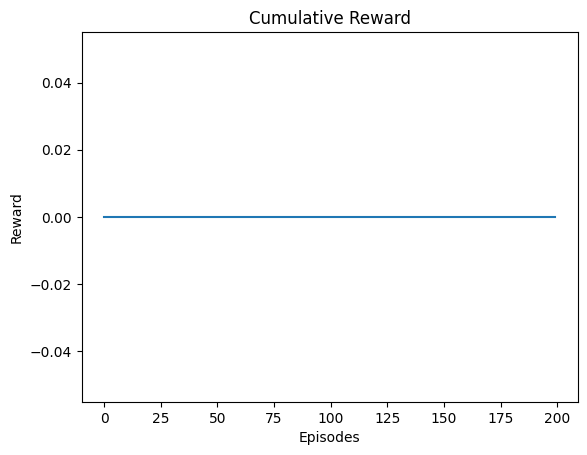

In [124]:
plt.title("Cumulative Reward")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(ma.cumulative_rewards)
plt.show()

#### WHY does the agent take an actions in the given state?

In [125]:
#we took 10% of experience replay samples as test data. The agent has not seen this yet
print(random_episodes)
len(sampled_inputs)

[ 60  84 157  45 160 194   7 188  40 108 138 140 141 120 129 133  88 151
  89  73]


20

In [126]:
x = sampling_episode
print(x)

[7, 40, 45, 60, 73, 84, 88, 89, 108, 120, 129, 133, 138, 140, 141, 151, 157, 160, 188, 194]


In [127]:
#After halfway through its training lets see why the agent took the actions it did
s = math.ceil(len(x)/2)
print(s)

10


In [128]:
# The first sample is a tensor of pixels indicating an image
sampled_inputs[s]

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.2627, 0.2627, 0.2627],
          [0.0000, 0.0000, 0.0000,  ..., 0.5804, 0.5804, 0.5804],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]])

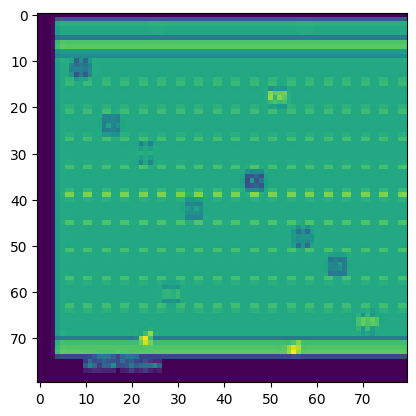

In [129]:
# we can see what that image is
plt.imshow(sampled_inputs[s].view(80, 80, 1))
plt.show()

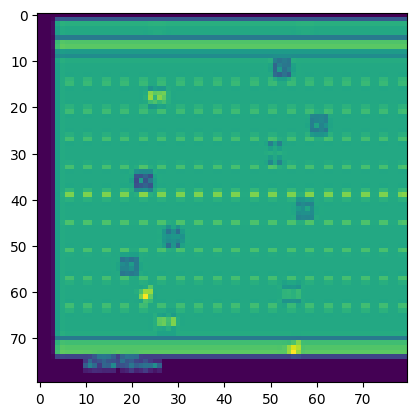

In [130]:
# we then see what the next image is
plt.imshow(sampled_inputs[s+1].view(80, 80, 1))
plt.show()

In [131]:
# we see what Q values were calculated for each action for first image
sampled_targets[s]
#['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

tensor([[0.0003, 0.0004, 0.0004]])

In [132]:
# we see what Q values were calculated for each action for second image
sampled_targets[s+1]
#['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

tensor([[1.3713e-06, 1.3327e-06, 1.3807e-06]])

In [133]:
background = sampled_inputs[s] #we use the first image for shap explainer
test_image = sampled_inputs[s+1] #we use the second image for testing shap explainer

In [134]:
e = shap.DeepExplainer(cnn, background) # train shap explainer

In [135]:
shap_values = e.shap_values(test_image) #get shap values for second image

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [136]:
shap_values

[array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]]]),
 array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]]]),
 array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]]])]

In [137]:
shap_values = torch.from_numpy(np.array(shap_values, dtype=np.float32)) #convert shap values into a tensor

In [138]:
shap_values.shape #this tensor has 6 samples, each having 1 channel, a height of 1, a width of 80, and a depth of 80.

torch.Size([3, 1, 1, 80, 80])

In [139]:
shap_values[0].shape # shap_value sample is an image

torch.Size([1, 1, 80, 80])

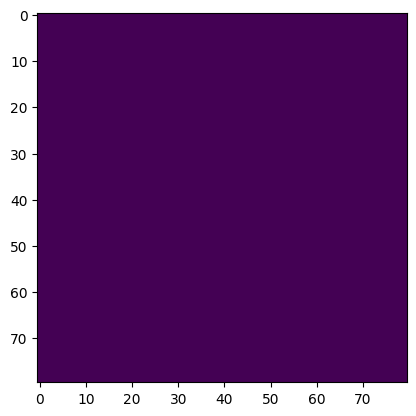

In [140]:
plt.imshow(shap_values[0].view(80, 80, 1))
plt.show() # image shows the importance of each action


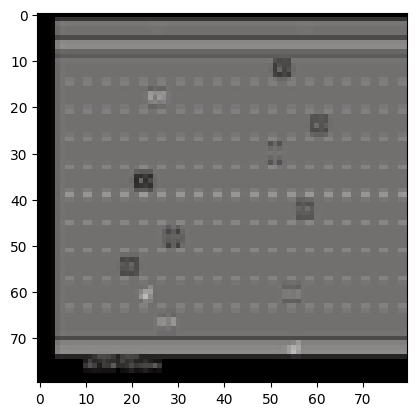

In [141]:
plt.imshow(sampled_inputs[s+1].view(80, 80, 1), cmap='gray') #['NOOP', 'FIRE', 'RIGHT', 'LEFT']
plt.imshow(shap_values[0].view(80, 80, 1), cmap='hot', alpha=0.1) #0=NOOP
plt.imshow(shap_values[1].view(80, 80, 1), cmap='hot', alpha=0.1) #1=UP
plt.imshow(shap_values[2].view(80, 80, 1), cmap='hot', alpha=0.1) #2=DOWN

### 10,000 Capacity Size

#### Setup Preprocessed Environment

In [142]:
env = gym.make('ALE/Freeway-v5')

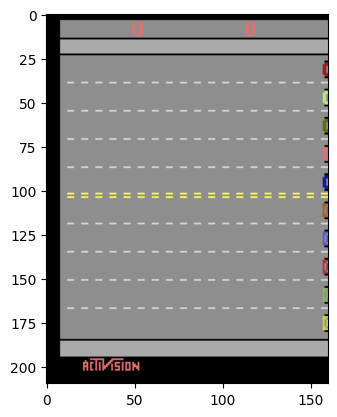

before image preprocessing: shape (210, 160, 3)


In [143]:
observation, info = env.reset(seed=42)
plt.imshow(observation)
plt.show()
print("before image preprocessing: shape " + str(observation.shape))

In [144]:
#We first preprocess the image by applying a greyscale and reducing the size to 80px. 
env = ImagePreprocessor(gym.make('ALE/Freeway-v5'), width=80, height=80, grayscale=True) #width=210, height=160 # , render_mode='human'

In [145]:
observation, info = env.reset(seed=42)

In [146]:
print(observation.shape) #we check that images are stacked

(1, 80, 80)


#### Create DCQL Agent

In [147]:
a = env.action_space.n # actions
g = 0.9 #gamma
c = 10000 #10000 #memory capacity
m = 128 #memory sampling
l = 0.001 #learning rate
t = 1.0 #softmax policy temperature rate

#Build the agent
cnn = CNN(a)
softmax = SoftmaxPolicy(T=t) # T is temperature high means other actions are less explored
agent = DCQ(CNN=cnn, SoftmaxPolicy=softmax)

# Set up Experience Replay
n_steps = NStepProgress(env=env, ai=agent, n_step=10) #instead of learning every transition we learn every nth transition
memory = ReplayMemory(n_steps=n_steps, capacity=c) #last ten thousand steps

#set learning parameters
loss = nn.MSELoss()#calculate mean squared error loss
optimizer = optim.Adam(cnn.parameters(), lr=l) #use adams optimiser with a learning rate of 0.001

ma = MA(100)#get the average of the last 100 rewards

#### Simulate the environment

In [148]:
episodes = 200 #200

# Initialize an empty list to store the sampled inputs for SHAP Explainer
# set a sampling rate based on episodes as batches could be zero if not enough available at start

#define a random selection size such as 10%
random_select_size = math.ceil(episodes * 0.1) # 10%

# Create an array of random episode numbers
random_episodes = np.random.choice(range(episodes), size=random_select_size, replace=False)

# Initialize an empty list to store the sampled inputs for SHAP Explainer
sampling_episode = []
sampled_inputs = []
sampled_targets = []
episode_sampled = False  # Initialize the flag

for episode in range(episodes):
    #run the game for 200 runs of 10 steps and push sample transitions into memory
    memory.run_steps(samples=200)
    #sample 128 x10['state', 'action', 'reward', 'done'] or 1,280 transitions from memory if there is enough in memory to sample otherwise skip
    for batch in memory.sample_batch(m): #m=128
        #agent training
        #we get target discounted q values for the first state in the batch over 10 steps
        inputs, targets = eligibility_trace(batch, cnn, g)

        #We take some samples for shap.deepxplainer to create heatmap images or we use them for training. Not both!
        if episode in random_episodes and not episode_sampled:
            sampling_episode.append(episode) #record when sample was taken
            sampled_inputs.append(inputs)
            sampled_targets.append(targets)
            episode_sampled = True # Set the flag to True
        else:
            #we convert them to tensor variables
            inputs, targets = Variable(inputs), Variable(targets)

            #like during eligibility_trace we get predicted q values from the cnn model
            predictions = cnn(inputs)
            loss_error = loss(predictions, targets)
            optimizer.zero_grad()
            loss_error.backward()
            optimizer.step()
    
    episode_sampled = False # Reset the flag for the next iteration
            
    rewards_steps = n_steps.rewards_steps()
    ma.add(rewards_steps)
    avg_reward = ma.average()
    print("Epoch: %s, Average Reward: %s" % (str(episode), str(round(avg_reward,2))))
env.close()

Epoch: 0, Average Reward: 0.0
Epoch: 1, Average Reward: 0.0
Epoch: 2, Average Reward: 0.0
Epoch: 3, Average Reward: 0.0
Epoch: 4, Average Reward: 0.0
Epoch: 5, Average Reward: 0.0
Epoch: 6, Average Reward: 0.0
Epoch: 7, Average Reward: 0.0
Epoch: 8, Average Reward: 0.0
Epoch: 9, Average Reward: 0.0
Epoch: 10, Average Reward: 0.0
Epoch: 11, Average Reward: 0.0
Epoch: 12, Average Reward: 0.0
Epoch: 13, Average Reward: 0.0
Epoch: 14, Average Reward: 0.0
Epoch: 15, Average Reward: 0.0
Epoch: 16, Average Reward: 0.0
Epoch: 17, Average Reward: 0.0
Epoch: 18, Average Reward: 0.0
Epoch: 19, Average Reward: 0.0
Epoch: 20, Average Reward: 0.0
Epoch: 21, Average Reward: 0.0
Epoch: 22, Average Reward: 0.0
Epoch: 23, Average Reward: 0.0
Epoch: 24, Average Reward: 0.0
Epoch: 25, Average Reward: 0.0
Epoch: 26, Average Reward: 0.0
Epoch: 27, Average Reward: 0.0
Epoch: 28, Average Reward: 0.0
Epoch: 29, Average Reward: 0.0
Epoch: 30, Average Reward: 0.0
Epoch: 31, Average Reward: 0.0
Epoch: 32, Average

#### HOW did the agent performed?

##### Agent's final score

In [149]:
#Current sum of all values in the reward window
print(ma.max_reward) #595.0

0


##### Rewards at given time/step

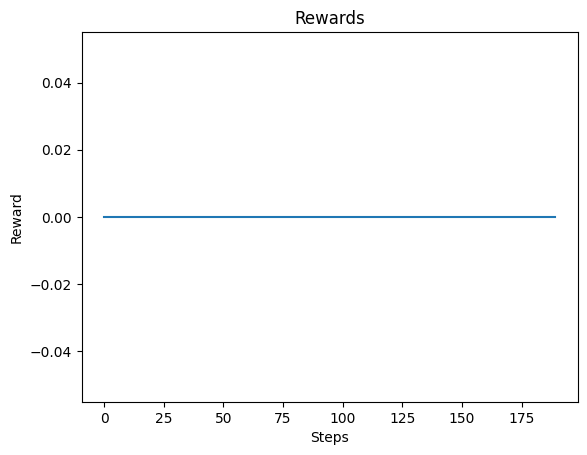

In [150]:
# Iterate over the rows of average_rewards and append them to df_rewards
for episode, reward in enumerate(ma.average_rewards):
    new_row = ["10k", episode, reward]
    df_rewards.loc[len(df_rewards)] = new_row
    
# Save and plot reward
plt.title("Rewards")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.plot(ma.average_rewards)
plt.show()

In [151]:
len(ma.average_rewards)#reward only counted if given.

190

##### Cumulative reward over time/step

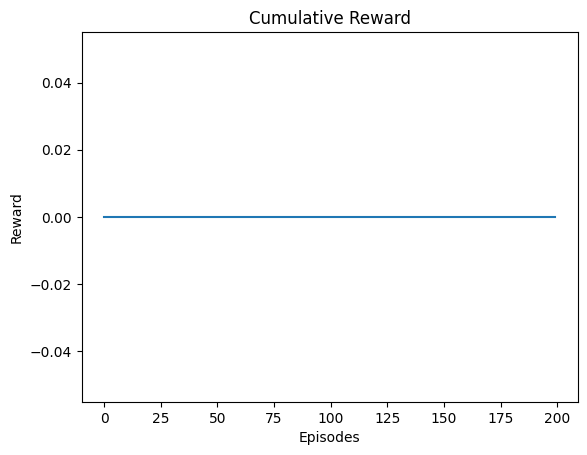

In [152]:
plt.title("Cumulative Reward")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(ma.cumulative_rewards)
plt.show()

#### WHY does the agent take an actions in the given state?

In [153]:
#we took 10% of experience replay samples as test data. The agent has not seen this yet
print(random_episodes)
len(sampled_inputs)

[ 61 121 104  80  81 190 149 158  66 188  90  89 154 157 132 127 120 134
 124  37]


20

In [154]:
x = sampling_episode
print(x)

[37, 61, 66, 80, 81, 89, 90, 104, 120, 121, 124, 127, 132, 134, 149, 154, 157, 158, 188, 190]


In [155]:
#After halfway through its training lets see why the agent took the actions it did
s = math.ceil(len(x)/2)
print(s)

10


In [156]:
# The first sample is a tensor of pixels indicating an image
sampled_inputs[s]

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.2627, 0.2627, 0.2627],
          [0.0000, 0.0000, 0.0000,  ..., 0.5804, 0.5804, 0.5804],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]])

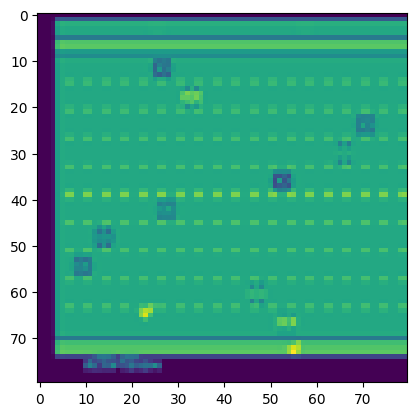

In [157]:
# we can see what that image is
plt.imshow(sampled_inputs[s].view(80, 80, 1))
plt.show()

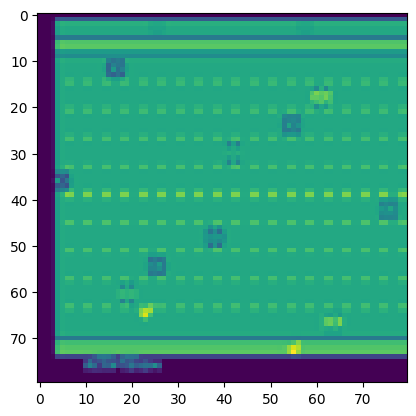

In [158]:
# we then see what the next image is
plt.imshow(sampled_inputs[s+1].view(80, 80, 1))
plt.show()

In [159]:
# we see what Q values were calculated for each action for first image
sampled_targets[s]
#['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

tensor([[3.8579e-05, 4.1641e-05, 4.2865e-05]])

In [160]:
# we see what Q values were calculated for each action for second image
sampled_targets[s+1]
#['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

tensor([[3.7400e-06, 4.1556e-06, 3.7070e-06]])

In [161]:
background = sampled_inputs[s] #we use the first image for shap explainer
test_image = sampled_inputs[s+1] #we use the second image for testing shap explainer

In [162]:
e = shap.DeepExplainer(cnn, background) # train shap explainer

In [163]:
shap_values = e.shap_values(test_image) #get shap values for second image

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [164]:
shap_values

[array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]]]),
 array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]]]),
 array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]]])]

In [165]:
shap_values = torch.from_numpy(np.array(shap_values, dtype=np.float32)) #convert shap values into a tensor

In [166]:
shap_values.shape #this tensor has 6 samples, each having 1 channel, a height of 1, a width of 80, and a depth of 80.

torch.Size([3, 1, 1, 80, 80])

In [167]:
shap_values[0].shape # shap_value sample is an image

torch.Size([1, 1, 80, 80])

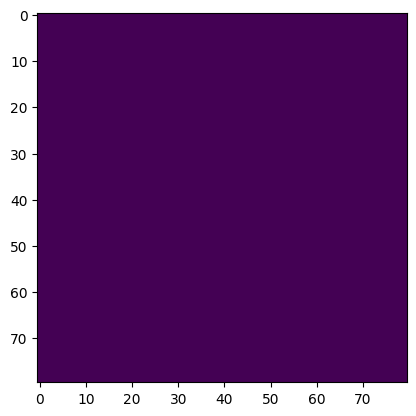

In [168]:
plt.imshow(shap_values[0].view(80, 80, 1))
plt.show() # image shows the importance of each action


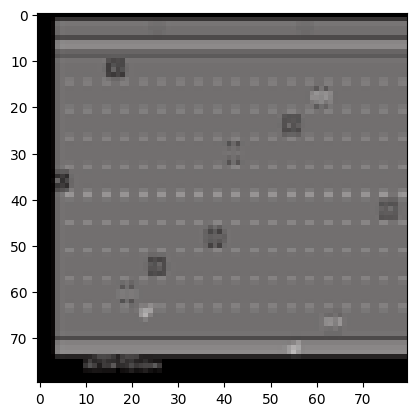

In [169]:
plt.imshow(sampled_inputs[s+1].view(80, 80, 1), cmap='gray') #['NOOP', 'FIRE', 'RIGHT', 'LEFT']
plt.imshow(shap_values[0].view(80, 80, 1), cmap='hot', alpha=0.1) #0=NOOP
plt.imshow(shap_values[1].view(80, 80, 1), cmap='hot', alpha=0.1) #1=UP
plt.imshow(shap_values[2].view(80, 80, 1), cmap='hot', alpha=0.1) #2=DOWN

### 5,000 Capacity Size

#### Setup Preprocessed Environment

In [170]:
env = gym.make('ALE/Freeway-v5')

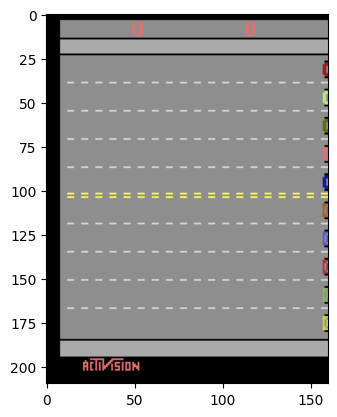

before image preprocessing: shape (210, 160, 3)


In [171]:
observation, info = env.reset(seed=42)
plt.imshow(observation)
plt.show()
print("before image preprocessing: shape " + str(observation.shape))

In [172]:
#We first preprocess the image by applying a greyscale and reducing the size to 80px. 
env = ImagePreprocessor(gym.make('ALE/Freeway-v5'), width=80, height=80, grayscale=True) #width=210, height=160 # , render_mode='human'

In [173]:
observation, info = env.reset(seed=42)

In [174]:
print(observation.shape) #we check that images are stacked

(1, 80, 80)


#### Create DCQL Agent

In [175]:
a = env.action_space.n # actions
g = 0.9 #gamma
c = 5000 #10000 #memory capacity
m = 128 #memory sampling
l = 0.001 #learning rate
t = 1.0 #softmax policy temperature rate

#Build the agent
cnn = CNN(a)
softmax = SoftmaxPolicy(T=t) # T is temperature high means other actions are less explored
agent = DCQ(CNN=cnn, SoftmaxPolicy=softmax)

# Set up Experience Replay
n_steps = NStepProgress(env=env, ai=agent, n_step=10) #instead of learning every transition we learn every nth transition
memory = ReplayMemory(n_steps=n_steps, capacity=c) #last ten thousand steps

#set learning parameters
loss = nn.MSELoss()#calculate mean squared error loss
optimizer = optim.Adam(cnn.parameters(), lr=l) #use adams optimiser with a learning rate of 0.001

ma = MA(100)#get the average of the last 100 rewards

#### Simulate the environment

In [176]:
episodes = 200 #200

# Initialize an empty list to store the sampled inputs for SHAP Explainer
# set a sampling rate based on episodes as batches could be zero if not enough available at start

#define a random selection size such as 10%
random_select_size = math.ceil(episodes * 0.1) # 10%

# Create an array of random episode numbers
random_episodes = np.random.choice(range(episodes), size=random_select_size, replace=False)

# Initialize an empty list to store the sampled inputs for SHAP Explainer
sampling_episode = []
sampled_inputs = []
sampled_targets = []
episode_sampled = False  # Initialize the flag

for episode in range(episodes):
    #run the game for 200 runs of 10 steps and push sample transitions into memory
    memory.run_steps(samples=200)
    #sample 128 x10['state', 'action', 'reward', 'done'] or 1,280 transitions from memory if there is enough in memory to sample otherwise skip
    for batch in memory.sample_batch(m): #m=128
        #agent training
        #we get target discounted q values for the first state in the batch over 10 steps
        inputs, targets = eligibility_trace(batch, cnn, g)

        #We take some samples for shap.deepxplainer to create heatmap images or we use them for training. Not both!
        if episode in random_episodes and not episode_sampled:
            sampling_episode.append(episode) #record when sample was taken
            sampled_inputs.append(inputs)
            sampled_targets.append(targets)
            episode_sampled = True # Set the flag to True
        else:
            #we convert them to tensor variables
            inputs, targets = Variable(inputs), Variable(targets)

            #like during eligibility_trace we get predicted q values from the cnn model
            predictions = cnn(inputs)
            loss_error = loss(predictions, targets)
            optimizer.zero_grad()
            loss_error.backward()
            optimizer.step()
    
    episode_sampled = False # Reset the flag for the next iteration
            
    rewards_steps = n_steps.rewards_steps()
    ma.add(rewards_steps)
    avg_reward = ma.average()
    print("Epoch: %s, Average Reward: %s" % (str(episode), str(round(avg_reward,2))))
env.close()

Epoch: 0, Average Reward: 0.0
Epoch: 1, Average Reward: 0.0
Epoch: 2, Average Reward: 0.0
Epoch: 3, Average Reward: 0.0
Epoch: 4, Average Reward: 0.0
Epoch: 5, Average Reward: 0.0
Epoch: 6, Average Reward: 0.0
Epoch: 7, Average Reward: 0.0
Epoch: 8, Average Reward: 0.0
Epoch: 9, Average Reward: 0.0
Epoch: 10, Average Reward: 0.0
Epoch: 11, Average Reward: 0.0
Epoch: 12, Average Reward: 0.0
Epoch: 13, Average Reward: 0.0
Epoch: 14, Average Reward: 0.0
Epoch: 15, Average Reward: 0.0
Epoch: 16, Average Reward: 0.0
Epoch: 17, Average Reward: 0.0
Epoch: 18, Average Reward: 0.0
Epoch: 19, Average Reward: 0.0
Epoch: 20, Average Reward: 0.0
Epoch: 21, Average Reward: 0.0
Epoch: 22, Average Reward: 0.0
Epoch: 23, Average Reward: 0.0
Epoch: 24, Average Reward: 0.0
Epoch: 25, Average Reward: 0.0
Epoch: 26, Average Reward: 0.0
Epoch: 27, Average Reward: 0.0
Epoch: 28, Average Reward: 0.0
Epoch: 29, Average Reward: 0.0
Epoch: 30, Average Reward: 0.0
Epoch: 31, Average Reward: 0.0
Epoch: 32, Average

#### HOW did the agent performed?

##### Agent's final score

In [177]:
#Current sum of all values in the reward window
print(ma.max_reward) #595.0

0


##### Rewards at given time/step

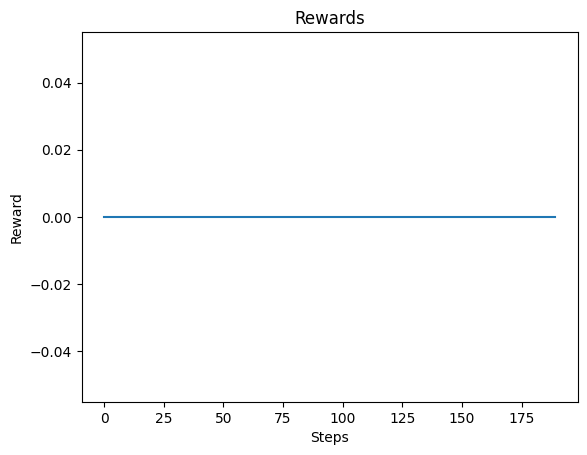

In [178]:
# Iterate over the rows of average_rewards and append them to df_rewards
for episode, reward in enumerate(ma.average_rewards):
    new_row = ["5k", episode, reward]
    df_rewards.loc[len(df_rewards)] = new_row
    
# Save and plot reward
plt.title("Rewards")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.plot(ma.average_rewards)
plt.show()

In [179]:
len(ma.average_rewards)#reward only counted if given.

190

##### Cumulative reward over time/step

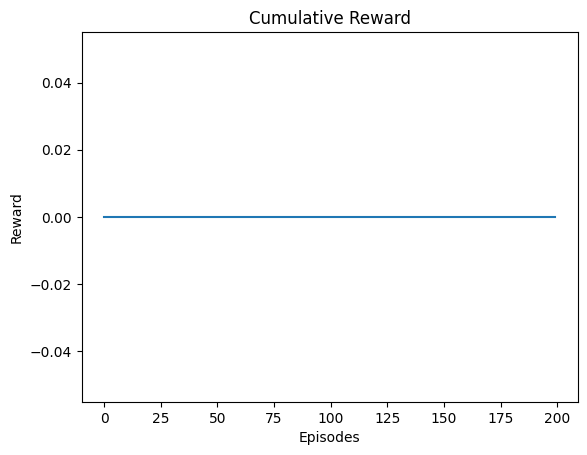

In [180]:
plt.title("Cumulative Reward")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(ma.cumulative_rewards)
plt.show()

#### WHY does the agent take an actions in the given state?

In [181]:
#we took 10% of experience replay samples as test data. The agent has not seen this yet
print(random_episodes)
len(sampled_inputs)

[ 65  92 109 196   1 119 161 154  78 195  24  36 132  77 185 106 166  70
  93 112]


20

In [182]:
x = sampling_episode
print(x)

[1, 24, 36, 65, 70, 77, 78, 92, 93, 106, 109, 112, 119, 132, 154, 161, 166, 185, 195, 196]


In [183]:
#After halfway through its training lets see why the agent took the actions it did
s = math.ceil(len(x)/2)
print(s)

10


In [184]:
# The first sample is a tensor of pixels indicating an image
sampled_inputs[s]

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.2627, 0.2627, 0.2627],
          [0.0000, 0.0000, 0.0000,  ..., 0.5804, 0.5804, 0.5804],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]])

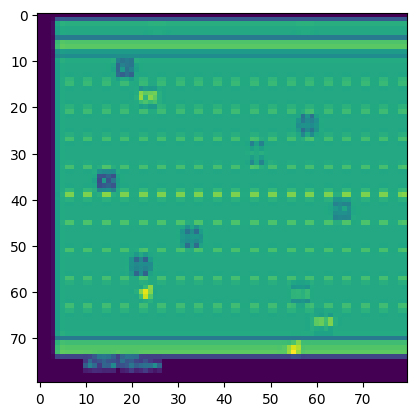

In [185]:
# we can see what that image is
plt.imshow(sampled_inputs[s].view(80, 80, 1))
plt.show()

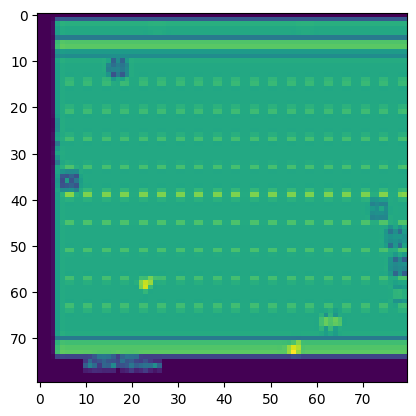

In [186]:
# we then see what the next image is
plt.imshow(sampled_inputs[s+1].view(80, 80, 1))
plt.show()

In [187]:
# we see what Q values were calculated for each action for first image
sampled_targets[s]
#['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

tensor([[0.0979, 0.1106, 0.1232]])

In [188]:
# we see what Q values were calculated for each action for second image
sampled_targets[s+1]
#['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

tensor([[0.0757, 0.0902, 0.0812]])

In [189]:
background = sampled_inputs[s] #we use the first image for shap explainer
test_image = sampled_inputs[s+1] #we use the second image for testing shap explainer

In [190]:
e = shap.DeepExplainer(cnn, background) # train shap explainer

In [191]:
shap_values = e.shap_values(test_image) #get shap values for second image

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [192]:
shap_values

[array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]]]),
 array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]]]),
 array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]]])]

In [193]:
shap_values = torch.from_numpy(np.array(shap_values, dtype=np.float32)) #convert shap values into a tensor

In [194]:
shap_values.shape #this tensor has 6 samples, each having 1 channel, a height of 1, a width of 80, and a depth of 80.

torch.Size([3, 1, 1, 80, 80])

In [195]:
shap_values[0].shape # shap_value sample is an image

torch.Size([1, 1, 80, 80])

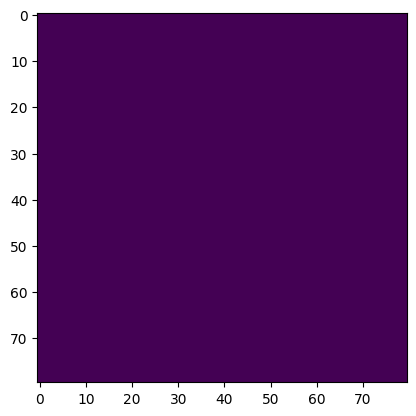

In [196]:
plt.imshow(shap_values[0].view(80, 80, 1))
plt.show() # image shows the importance of each action


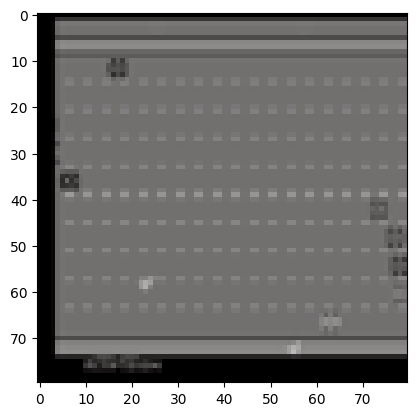

In [197]:
plt.imshow(sampled_inputs[s+1].view(80, 80, 1), cmap='gray') #['NOOP', 'FIRE', 'RIGHT', 'LEFT']
plt.imshow(shap_values[0].view(80, 80, 1), cmap='hot', alpha=0.1) #0=NOOP
plt.imshow(shap_values[1].view(80, 80, 1), cmap='hot', alpha=0.1) #1=UP
plt.imshow(shap_values[2].view(80, 80, 1), cmap='hot', alpha=0.1) #2=DOWN

### 1,000 Capacity Size

#### Setup Preprocessed Environment

In [198]:
env = gym.make('ALE/Freeway-v5')

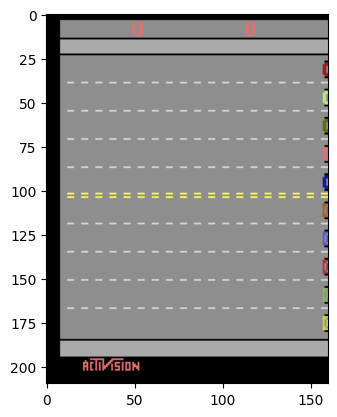

before image preprocessing: shape (210, 160, 3)


In [199]:
observation, info = env.reset(seed=42)
plt.imshow(observation)
plt.show()
print("before image preprocessing: shape " + str(observation.shape))

In [200]:
#We first preprocess the image by applying a greyscale and reducing the size to 80px. 
env = ImagePreprocessor(gym.make('ALE/Freeway-v5'), width=80, height=80, grayscale=True) #width=210, height=160 # , render_mode='human'

In [201]:
observation, info = env.reset(seed=42)

In [202]:
print(observation.shape) #we check that images are stacked

(1, 80, 80)


#### Create DCQL Agent

In [203]:
a = env.action_space.n # actions
g = 0.9 #gamma
c = 1000 #10000 #memory capacity
m = 128 #memory sampling
l = 0.001 #learning rate
t = 1.0 #softmax policy temperature rate

#Build the agent
cnn = CNN(a)
softmax = SoftmaxPolicy(T=t) # T is temperature high means other actions are less explored
agent = DCQ(CNN=cnn, SoftmaxPolicy=softmax)

# Set up Experience Replay
n_steps = NStepProgress(env=env, ai=agent, n_step=10) #instead of learning every transition we learn every nth transition
memory = ReplayMemory(n_steps=n_steps, capacity=c) #last ten thousand steps

#set learning parameters
loss = nn.MSELoss()#calculate mean squared error loss
optimizer = optim.Adam(cnn.parameters(), lr=l) #use adams optimiser with a learning rate of 0.001

ma = MA(100)#get the average of the last 100 rewards

#### Simulate the environment

In [204]:
episodes = 200 #200

# Initialize an empty list to store the sampled inputs for SHAP Explainer
# set a sampling rate based on episodes as batches could be zero if not enough available at start

#define a random selection size such as 10%
random_select_size = math.ceil(episodes * 0.1) # 10%

# Create an array of random episode numbers
random_episodes = np.random.choice(range(episodes), size=random_select_size, replace=False)

# Initialize an empty list to store the sampled inputs for SHAP Explainer
sampling_episode = []
sampled_inputs = []
sampled_targets = []
episode_sampled = False  # Initialize the flag

for episode in range(episodes):
    #run the game for 200 runs of 10 steps and push sample transitions into memory
    memory.run_steps(samples=200)
    #sample 128 x10['state', 'action', 'reward', 'done'] or 1,280 transitions from memory if there is enough in memory to sample otherwise skip
    for batch in memory.sample_batch(m): #m=128
        #agent training
        #we get target discounted q values for the first state in the batch over 10 steps
        inputs, targets = eligibility_trace(batch, cnn, g)

        #We take some samples for shap.deepxplainer to create heatmap images or we use them for training. Not both!
        if episode in random_episodes and not episode_sampled:
            sampling_episode.append(episode) #record when sample was taken
            sampled_inputs.append(inputs)
            sampled_targets.append(targets)
            episode_sampled = True # Set the flag to True
        else:
            #we convert them to tensor variables
            inputs, targets = Variable(inputs), Variable(targets)

            #like during eligibility_trace we get predicted q values from the cnn model
            predictions = cnn(inputs)
            loss_error = loss(predictions, targets)
            optimizer.zero_grad()
            loss_error.backward()
            optimizer.step()
    
    episode_sampled = False # Reset the flag for the next iteration
            
    rewards_steps = n_steps.rewards_steps()
    ma.add(rewards_steps)
    avg_reward = ma.average()
    print("Epoch: %s, Average Reward: %s" % (str(episode), str(round(avg_reward,2))))
env.close()

Epoch: 0, Average Reward: 0.0
Epoch: 1, Average Reward: 0.0
Epoch: 2, Average Reward: 0.0
Epoch: 3, Average Reward: 0.0
Epoch: 4, Average Reward: 0.0
Epoch: 5, Average Reward: 0.0
Epoch: 6, Average Reward: 0.0
Epoch: 7, Average Reward: 0.0
Epoch: 8, Average Reward: 0.0
Epoch: 9, Average Reward: 0.0
Epoch: 10, Average Reward: 0.0
Epoch: 11, Average Reward: 0.0
Epoch: 12, Average Reward: 0.0
Epoch: 13, Average Reward: 0.0
Epoch: 14, Average Reward: 0.0
Epoch: 15, Average Reward: 0.0
Epoch: 16, Average Reward: 0.0
Epoch: 17, Average Reward: 0.0
Epoch: 18, Average Reward: 0.0
Epoch: 19, Average Reward: 0.0
Epoch: 20, Average Reward: 0.0
Epoch: 21, Average Reward: 0.0
Epoch: 22, Average Reward: 0.0
Epoch: 23, Average Reward: 0.0
Epoch: 24, Average Reward: 0.0
Epoch: 25, Average Reward: 0.0
Epoch: 26, Average Reward: 0.0
Epoch: 27, Average Reward: 0.0
Epoch: 28, Average Reward: 0.0
Epoch: 29, Average Reward: 0.0
Epoch: 30, Average Reward: 0.0
Epoch: 31, Average Reward: 0.0
Epoch: 32, Average

#### HOW did the agent performed?

##### Agent's final score

In [205]:
#Current sum of all values in the reward window
print(ma.max_reward) #595.0

0


##### Rewards at given time/step

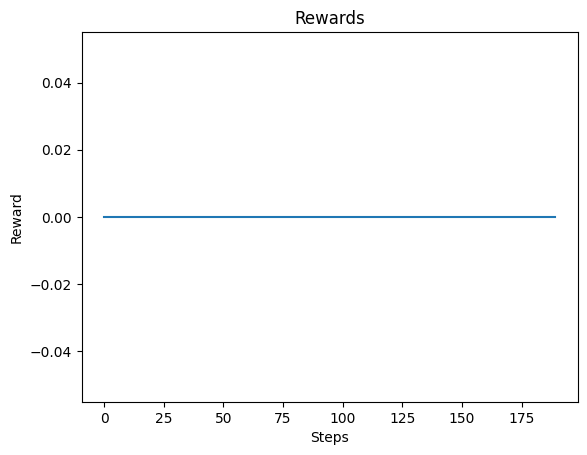

In [206]:
# Iterate over the rows of average_rewards and append them to df_rewards
for episode, reward in enumerate(ma.average_rewards):
    new_row = ["1k", episode, reward]
    df_rewards.loc[len(df_rewards)] = new_row
    
# Save and plot reward
plt.title("Rewards")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.plot(ma.average_rewards)
plt.show()

In [207]:
len(ma.average_rewards)#reward only counted if given.

190

##### Cumulative reward over time/step

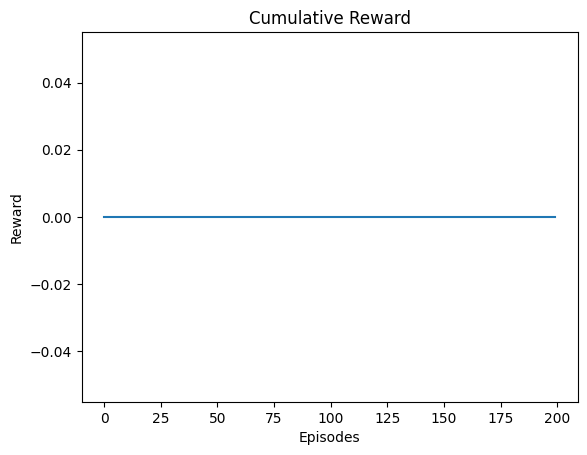

In [208]:
plt.title("Cumulative Reward")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(ma.cumulative_rewards)
plt.show()

#### WHY does the agent take an actions in the given state?

In [209]:
#we took 10% of experience replay samples as test data. The agent has not seen this yet
print(random_episodes)
len(sampled_inputs)

[ 97 158 190  31   4 135  51 169  68  75  95  91  56  83 119 189 175  46
 163  22]


20

In [210]:
x = sampling_episode
print(x)

[4, 22, 31, 46, 51, 56, 68, 75, 83, 91, 95, 97, 119, 135, 158, 163, 169, 175, 189, 190]


In [211]:
#After halfway through its training lets see why the agent took the actions it did
s = math.ceil(len(x)/2)
print(s)

10


In [212]:
# The first sample is a tensor of pixels indicating an image
sampled_inputs[s]

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.2627, 0.2627, 0.2627],
          [0.0000, 0.0000, 0.0000,  ..., 0.5804, 0.5804, 0.5804],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]])

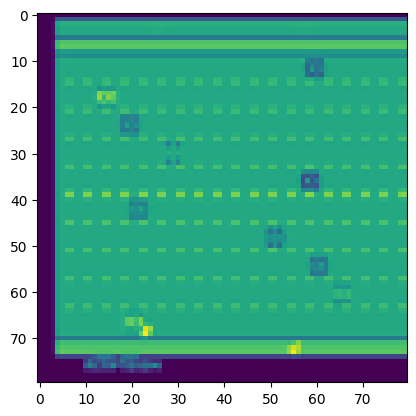

In [213]:
# we can see what that image is
plt.imshow(sampled_inputs[s].view(80, 80, 1))
plt.show()

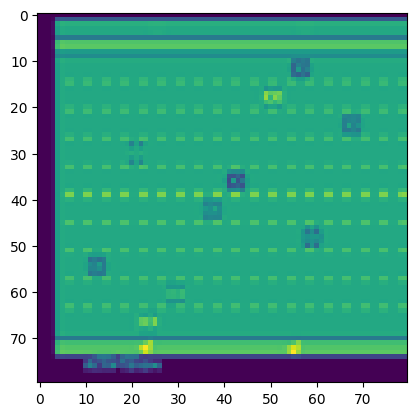

In [214]:
# we then see what the next image is
plt.imshow(sampled_inputs[s+1].view(80, 80, 1))
plt.show()

In [215]:
# we see what Q values were calculated for each action for first image
sampled_targets[s]
#['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

tensor([[0.0013, 0.0014, 0.0009]])

In [216]:
# we see what Q values were calculated for each action for second image
sampled_targets[s+1]
#['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

tensor([[0.0023, 0.0014, 0.0025]])

In [217]:
background = sampled_inputs[s] #we use the first image for shap explainer
test_image = sampled_inputs[s+1] #we use the second image for testing shap explainer

In [218]:
e = shap.DeepExplainer(cnn, background) # train shap explainer

In [219]:
shap_values = e.shap_values(test_image) #get shap values for second image

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [220]:
shap_values

[array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]]]),
 array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]]]),
 array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]]])]

In [221]:
shap_values = torch.from_numpy(np.array(shap_values, dtype=np.float32)) #convert shap values into a tensor

In [222]:
shap_values.shape #this tensor has 6 samples, each having 1 channel, a height of 1, a width of 80, and a depth of 80.

torch.Size([3, 1, 1, 80, 80])

In [223]:
shap_values[0].shape # shap_value sample is an image

torch.Size([1, 1, 80, 80])

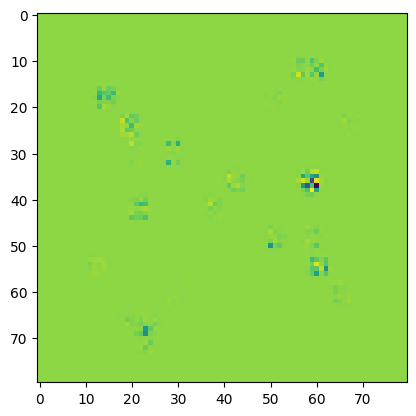

In [224]:
plt.imshow(shap_values[0].view(80, 80, 1))
plt.show() # image shows the importance of each action


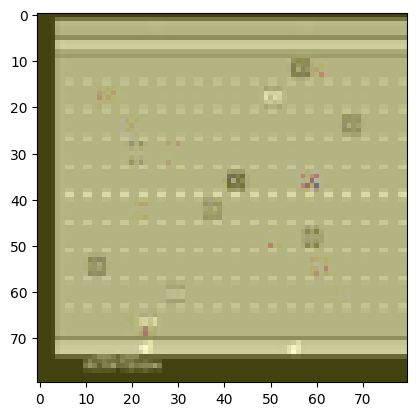

In [225]:
plt.imshow(sampled_inputs[s+1].view(80, 80, 1), cmap='gray') #['NOOP', 'FIRE', 'RIGHT', 'LEFT']
plt.imshow(shap_values[0].view(80, 80, 1), cmap='hot', alpha=0.1) #0=NOOP
plt.imshow(shap_values[1].view(80, 80, 1), cmap='hot', alpha=0.1) #1=UP
plt.imshow(shap_values[2].view(80, 80, 1), cmap='hot', alpha=0.1) #2=DOWN

### 500 Capacity Size

#### Setup Preprocessed Environment

In [226]:
env = gym.make('ALE/Freeway-v5')

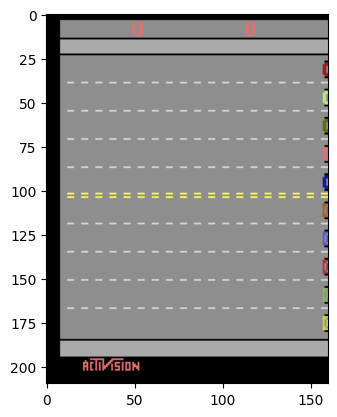

before image preprocessing: shape (210, 160, 3)


In [227]:
observation, info = env.reset(seed=42)
plt.imshow(observation)
plt.show()
print("before image preprocessing: shape " + str(observation.shape))

In [228]:
#We first preprocess the image by applying a greyscale and reducing the size to 80px. 
env = ImagePreprocessor(gym.make('ALE/Freeway-v5'), width=80, height=80, grayscale=True) #width=210, height=160 # , render_mode='human'

In [229]:
observation, info = env.reset(seed=42)

In [230]:
print(observation.shape) #we check that images are stacked

(1, 80, 80)


#### Create DCQL Agent

In [231]:
a = env.action_space.n # actions
g = 0.9 #gamma
c = 500 #10000 #memory capacity
m = 128 #memory sampling
l = 0.001 #learning rate
t = 1.0 #softmax policy temperature rate

#Build the agent
cnn = CNN(a)
softmax = SoftmaxPolicy(T=t) # T is temperature high means other actions are less explored
agent = DCQ(CNN=cnn, SoftmaxPolicy=softmax)

# Set up Experience Replay
n_steps = NStepProgress(env=env, ai=agent, n_step=10) #instead of learning every transition we learn every nth transition
memory = ReplayMemory(n_steps=n_steps, capacity=c) #last ten thousand steps

#set learning parameters
loss = nn.MSELoss()#calculate mean squared error loss
optimizer = optim.Adam(cnn.parameters(), lr=l) #use adams optimiser with a learning rate of 0.001

ma = MA(100)#get the average of the last 100 rewards

#### Simulate the environment

In [232]:
episodes = 200 #200

# Initialize an empty list to store the sampled inputs for SHAP Explainer
# set a sampling rate based on episodes as batches could be zero if not enough available at start

#define a random selection size such as 10%
random_select_size = math.ceil(episodes * 0.1) # 10%

# Create an array of random episode numbers
random_episodes = np.random.choice(range(episodes), size=random_select_size, replace=False)

# Initialize an empty list to store the sampled inputs for SHAP Explainer
sampling_episode = []
sampled_inputs = []
sampled_targets = []
episode_sampled = False  # Initialize the flag

for episode in range(episodes):
    #run the game for 200 runs of 10 steps and push sample transitions into memory
    memory.run_steps(samples=200)
    #sample 128 x10['state', 'action', 'reward', 'done'] or 1,280 transitions from memory if there is enough in memory to sample otherwise skip
    for batch in memory.sample_batch(m): #m=128
        #agent training
        #we get target discounted q values for the first state in the batch over 10 steps
        inputs, targets = eligibility_trace(batch, cnn, g)

        #We take some samples for shap.deepxplainer to create heatmap images or we use them for training. Not both!
        if episode in random_episodes and not episode_sampled:
            sampling_episode.append(episode) #record when sample was taken
            sampled_inputs.append(inputs)
            sampled_targets.append(targets)
            episode_sampled = True # Set the flag to True
        else:
            #we convert them to tensor variables
            inputs, targets = Variable(inputs), Variable(targets)

            #like during eligibility_trace we get predicted q values from the cnn model
            predictions = cnn(inputs)
            loss_error = loss(predictions, targets)
            optimizer.zero_grad()
            loss_error.backward()
            optimizer.step()
    
    episode_sampled = False # Reset the flag for the next iteration
            
    rewards_steps = n_steps.rewards_steps()
    ma.add(rewards_steps)
    avg_reward = ma.average()
    print("Epoch: %s, Average Reward: %s" % (str(episode), str(round(avg_reward,2))))
env.close()

Epoch: 0, Average Reward: 0.0
Epoch: 1, Average Reward: 0.0
Epoch: 2, Average Reward: 0.0
Epoch: 3, Average Reward: 0.0
Epoch: 4, Average Reward: 0.0
Epoch: 5, Average Reward: 0.0
Epoch: 6, Average Reward: 0.0
Epoch: 7, Average Reward: 0.0
Epoch: 8, Average Reward: 0.0
Epoch: 9, Average Reward: 0.0
Epoch: 10, Average Reward: 0.0
Epoch: 11, Average Reward: 0.0
Epoch: 12, Average Reward: 0.0
Epoch: 13, Average Reward: 0.0
Epoch: 14, Average Reward: 0.0
Epoch: 15, Average Reward: 0.0
Epoch: 16, Average Reward: 0.0
Epoch: 17, Average Reward: 0.0
Epoch: 18, Average Reward: 0.0
Epoch: 19, Average Reward: 0.0
Epoch: 20, Average Reward: 0.0
Epoch: 21, Average Reward: 0.0
Epoch: 22, Average Reward: 0.0
Epoch: 23, Average Reward: 0.0
Epoch: 24, Average Reward: 0.0
Epoch: 25, Average Reward: 0.0
Epoch: 26, Average Reward: 0.0
Epoch: 27, Average Reward: 0.0
Epoch: 28, Average Reward: 0.0
Epoch: 29, Average Reward: 0.0
Epoch: 30, Average Reward: 0.0
Epoch: 31, Average Reward: 0.0
Epoch: 32, Average

#### HOW did the agent performed?

##### Agent's final score

In [233]:
#Current sum of all values in the reward window
print(ma.max_reward) #595.0

0


##### Rewards at given time/step

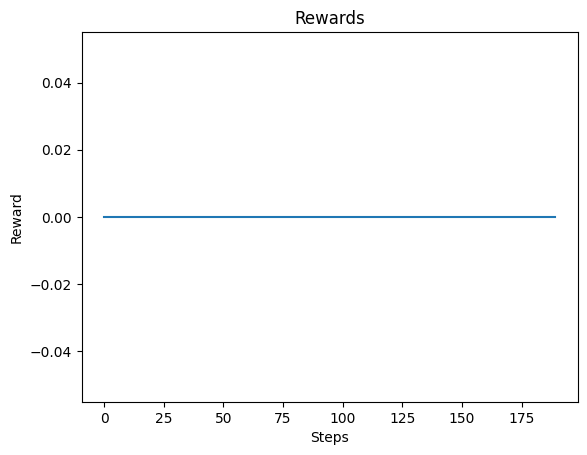

In [234]:
# Iterate over the rows of average_rewards and append them to df_rewards
for episode, reward in enumerate(ma.average_rewards):
    new_row = ["500", episode, reward]
    df_rewards.loc[len(df_rewards)] = new_row
    
# Save and plot reward
plt.title("Rewards")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.plot(ma.average_rewards)
plt.show()

In [235]:
len(ma.average_rewards)#reward only counted if given.

190

##### Cumulative reward over time/step

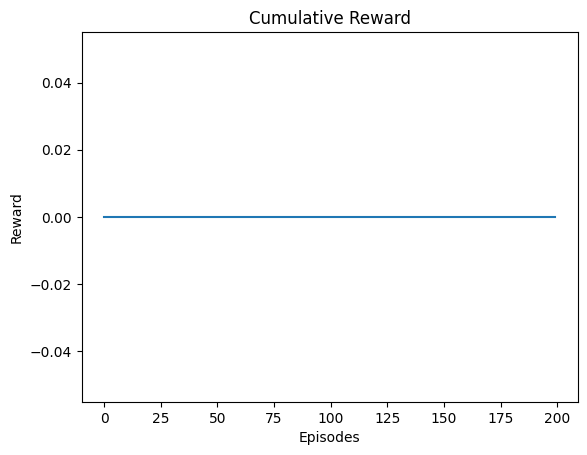

In [236]:
plt.title("Cumulative Reward")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(ma.cumulative_rewards)
plt.show()

#### WHY does the agent take an actions in the given state?

In [237]:
#we took 10% of experience replay samples as test data. The agent has not seen this yet
print(random_episodes)
len(sampled_inputs)

[ 51 132  69  77  25  36 156 176  22 183 105  52 113  85   6 103 117 141
 182  12]


20

In [238]:
x = sampling_episode
print(x)

[6, 12, 22, 25, 36, 51, 52, 69, 77, 85, 103, 105, 113, 117, 132, 141, 156, 176, 182, 183]


In [239]:
#After halfway through its training lets see why the agent took the actions it did
s = math.ceil(len(x)/2)
print(s)

10


In [240]:
# The first sample is a tensor of pixels indicating an image
sampled_inputs[s]

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.2627, 0.2627, 0.2627],
          [0.0000, 0.0000, 0.0000,  ..., 0.5804, 0.5804, 0.5804],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]])

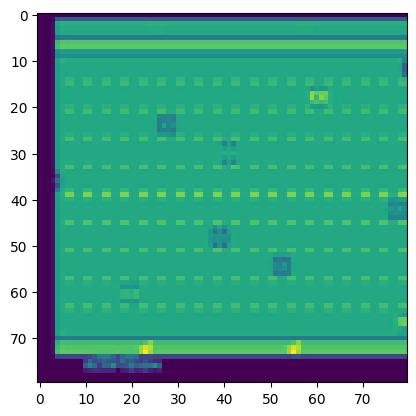

In [241]:
# we can see what that image is
plt.imshow(sampled_inputs[s].view(80, 80, 1))
plt.show()

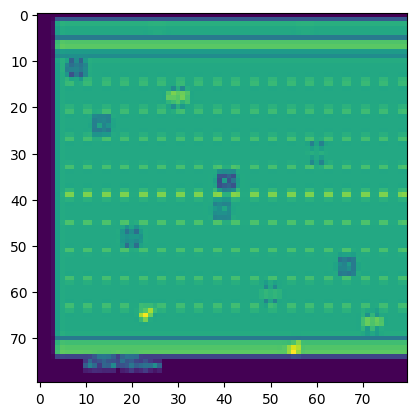

In [242]:
# we then see what the next image is
plt.imshow(sampled_inputs[s+1].view(80, 80, 1))
plt.show()

In [243]:
# we see what Q values were calculated for each action for first image
sampled_targets[s]
#['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

tensor([[0.0077, 0.0074, 0.0064]])

In [244]:
# we see what Q values were calculated for each action for second image
sampled_targets[s+1]
#['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

tensor([[0.0048, 0.0063, 0.0069]])

In [245]:
background = sampled_inputs[s] #we use the first image for shap explainer
test_image = sampled_inputs[s+1] #we use the second image for testing shap explainer

In [246]:
e = shap.DeepExplainer(cnn, background) # train shap explainer

In [247]:
shap_values = e.shap_values(test_image) #get shap values for second image

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [248]:
shap_values

[array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]]]),
 array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]]]),
 array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]]])]

In [249]:
shap_values = torch.from_numpy(np.array(shap_values, dtype=np.float32)) #convert shap values into a tensor

In [250]:
shap_values.shape #this tensor has 6 samples, each having 1 channel, a height of 1, a width of 80, and a depth of 80.

torch.Size([3, 1, 1, 80, 80])

In [251]:
shap_values[0].shape # shap_value sample is an image

torch.Size([1, 1, 80, 80])

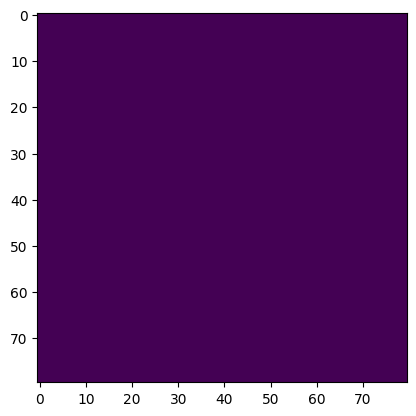

In [252]:
plt.imshow(shap_values[0].view(80, 80, 1))
plt.show() # image shows the importance of each action


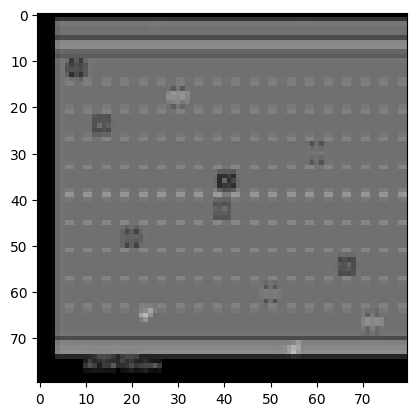

In [253]:
plt.imshow(sampled_inputs[s+1].view(80, 80, 1), cmap='gray') #['NOOP', 'FIRE', 'RIGHT', 'LEFT']
plt.imshow(shap_values[0].view(80, 80, 1), cmap='hot', alpha=0.1) #0=NOOP
plt.imshow(shap_values[1].view(80, 80, 1), cmap='hot', alpha=0.1) #1=UP
plt.imshow(shap_values[2].view(80, 80, 1), cmap='hot', alpha=0.1) #2=DOWN

## ANOVA

In [254]:
df_rewards.tail()

,capacity,episodes,reward
1515,500,185,0.0
1516,500,186,0.0
1517,500,187,0.0
1518,500,188,0.0
1519,500,189,0.0


In [255]:
x = datetime.datetime.now()
file_name = str(x.year) + "_" + str(x.month) + "_" + str(x.day) + "_" + str(x.strftime("%H")) + "_" + str(x.strftime("%M")) + "_" + str(x.strftime("%S")) + "_atari_freeway" + ".csv"
df_rewards.to_csv(file_name, index=False, encoding='utf-8')

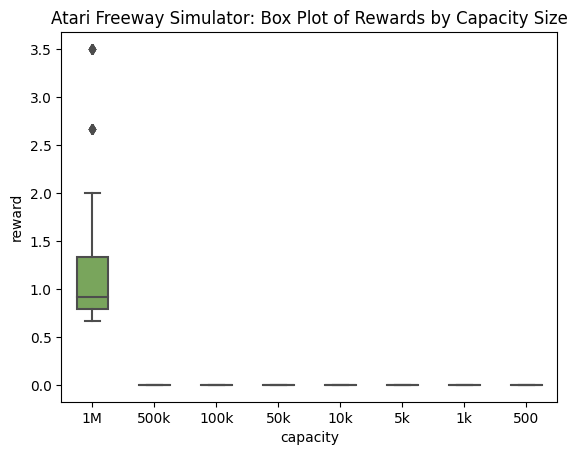

In [256]:
ax = sns.boxplot(x='capacity', y='reward', data=df_rewards, color='#77B150', width=0.5).set(title='Atari Freeway Simulator: Box Plot of Rewards by Capacity Size')
plt.show()

In [257]:
# Perform ANOVA and obtain group means
model = ols('reward ~ C(capacity)', data=df_rewards).fit()

In [258]:
group_means = df_rewards.groupby('capacity')['reward'].mean()
print(group_means)

capacity
100k    0.0000
10k     0.0000
1M      1.2445
1k      0.0000
500     0.0000
500k    0.0000
50k     0.0000
5k      0.0000
Name: reward, dtype: float64


In [259]:
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                 sum_sq      df           F  PR(>F)
C(capacity)  257.484592     7.0  554.149277     0.0
Residual     100.364061  1512.0         NaN     NaN


In [260]:
# Perform Tukey's HSD test
mc_results = mc.MultiComparison(df_rewards['reward'], df_rewards['capacity'])
tukey_results = mc_results.tukeyhsd()

In [261]:
# Print the results
print(tukey_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
  100k    10k      0.0   1.0 -0.0802  0.0802  False
  100k     1M   1.2445   0.0  1.1643  1.3247   True
  100k     1k      0.0   1.0 -0.0802  0.0802  False
  100k    500      0.0   1.0 -0.0802  0.0802  False
  100k   500k      0.0   1.0 -0.0802  0.0802  False
  100k    50k      0.0   1.0 -0.0802  0.0802  False
  100k     5k      0.0   1.0 -0.0802  0.0802  False
   10k     1M   1.2445   0.0  1.1643  1.3247   True
   10k     1k      0.0   1.0 -0.0802  0.0802  False
   10k    500      0.0   1.0 -0.0802  0.0802  False
   10k   500k      0.0   1.0 -0.0802  0.0802  False
   10k    50k      0.0   1.0 -0.0802  0.0802  False
   10k     5k      0.0   1.0 -0.0802  0.0802  False
    1M     1k  -1.2445   0.0 -1.3247 -1.1643   True
    1M    500  -1.2445   0.0 -1.3247 -1.1643   True
    1M   500k  -1.2445   0.0 -1.3247 -1.1643   True
    1M    50